# Análisis Exploratorio de Indicadores Urbanos en la Ciudad de Nueva York

**Consultor:** Julián Camilo Ramos Granada  
**Entrega para:** Gobierno de la Ciudad de Nueva York 
**Fecha:** Octubre de 2025


Este informe documenta el proceso de análisis de datos territoriales relacionados con problemáticas clave en el estado de Nueva York, específicamente: arrestos policiales, **accidentes viales, niveles de pobreza y educación pública. El objetivo de este trabajo es identificar patrones, correlaciones y elementos relevantes que puedan guiar la formulación de un plan de acción basado en evidencia, orientado a mejorar indicadores sociales y de seguridad pública.

A lo largo del documento se presentará el trabajo realizado con Apache Spark en un entorno distribuido, abordando grandes volúmenes de información mediante técnicas de análisis exploratorio, procesamiento y visualización de datos. Este proceso se enmarca dentro de la metodología CRISP-DM, que permite abordar proyectos de análisis de datos de forma estructurada y enfocada a resolver preguntas concretas.


## 1. Configuración del entorno de procesamiento en clúster HPC

Antes de realizar cualquier análisis, se establece la configuración de Spark y se crea la sesión de procesamiento en un entorno distribuido. El siguiente bloque de código muestra la inicialización de la sesión de Spark y la impresión de la sesión activa como validación del entorno configurado.


In [1]:
# Configuración del entorno PySpark desde Jupyter

# Inicializar el entorno
import findspark
findspark.init()

# Importación de bibliotecas principales de PySpark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.evaluation import RegressionEvaluator

# Configuración para la sesión Spark
configura = SparkConf().set("spark.scheduler.mode", "FAIR")
configura.setAppName("Proyecto_BigData_NY_2025")

# Creación de la sesión de Spark
spark = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

# Validación del contexto creado
contextoSpark = spark.sparkContext.getOrCreate()

#Evitar que salgan tantos warnings
spark.sparkContext.setLogLevel("ERROR")

print("Sesión Clúster HPC activa: Proyecto NY - Octubre 06, 2025")
spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/20 20:59:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/20 20:59:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesión Clúster HPC activa: Proyecto NY - Octubre 06, 2025


## 2. Carga y exploración de datasets territoriales

En esta sección se realiza la carga inicial y revisión estructural de los cuatro conjuntos de datos base del proyecto, cada uno relacionado con una dimensión crítica del bienestar territorial en el estado de Nueva York. Para cada uno, se describe el proceso de carga, la inspección de atributos, la exploración de los primeros registros y un resumen estadístico general. Este análisis inicial permitirá entender mejor la naturaleza de cada fuente y preparar el terreno para los análisis posteriores.

A continuación, se presentan los resultados obtenidos para cada uno de los datasets:


### 2.1 Exploración y calidad de datos: Arrestos en Nueva York

El primer conjunto de datos explorado corresponde al archivo `nypd_arrests.csv`, el cual contiene información detallada sobre los arrestos efectuados por el Departamento de Policía de Nueva York (NYPD) durante el año 2025. 

#### Carga y estructura de los datos

El archivo fue descargado directamente desde el portal oficial de datos abiertos de la Ciudad de Nueva York (NYC OpenData), y cargado desde el sistema de archivos del clúster HPC utilizando Apache Spark.

El conjunto de datos fue cargado exitosamente, con un total de **143,494 registros** distribuidos en **19 columnas**. A continuación se presenta el esquema general del dataset:

- `ARREST_KEY` (integer): identificador único del arresto.
- `ARREST_DATE` (string): fecha en la que ocurrió el arresto.
- `PD_CD` (integer): código de clasificación interna del NYPD.
- `PD_DESC` (string): descripción del tipo de delito según el NYPD.
- `KY_CD` (integer): código estándar de clasificación del delito.
- `OFNS_DESC` (string): descripción estandarizada del delito.
- `LAW_CODE` (string): código legal violado.
- `LAW_CAT_CD` (string): categoría del delito (`F`: felonía, `M`: delito menor, `V`: violación).
- `ARREST_BORO` (string): condado donde ocurrió el arresto (`B`, `M`, `Q`, `K`, `S`).
- `ARREST_PRECINCT` (integer): número de precinto donde se realizó el arresto.
- `JURISDICTION_CODE` (integer): código de jurisdicción del arresto.
- `AGE_GROUP` (string): grupo de edad del arrestado (`<18`, `18–24`, `25–44`, `45–64`, `65+`).
- `PERP_SEX` (string): sexo del arrestado.
- `PERP_RACE` (string): raza/etnia del arrestado.
- `X_COORD_CD`, `Y_COORD_CD` (integer): coordenadas cartesianas de localización.
- `Latitude`, `Longitude` (double): coordenadas geográficas del arresto.
- `New Georeferenced Column` (string): punto geográfico en formato WKT (Well-Known Text).

#### Vista preliminar de los datos

La visualización de las primeras filas muestra que los datos fueron cargados correctamente. Dentro de los datos se observan registros con distintas categorías delictivas, como robos, asaltos y leyes estatales específicas, así como diversidad en las edades, sexos y razas de los arrestados. También se identificaron casos con latitudes y longitudes igual a cero, lo que indica la presencia de registros sin georreferenciación.

#### Calidad de los datos

La revisión de valores nulos muestra que el dataset está mayormente completo, aunque se identifican algunas excepciones:

- La columna `KY_CD` presenta **10 valores nulos**.
- La columna `LAW_CAT_CD` presenta **687 valores nulos**, lo cual representa un 0.48% del total, y deberá considerarse durante el proceso de limpieza.
- Todas las demás columnas presentan **0 valores nulos** explícitos.

Por otro lado, **no existen registros repetidos** dentro del conjunto de datos.



In [2]:
# Descargar el dataset 
#!wget -O /home/estudiante/proyecto/nypd_arrests.csv "https://data.cityofnewyork.us/api/views/uip8-fykc/rows.csv?accessType=DOWNLOAD"

In [3]:
from pyspark.sql import functions as F

# Carga del dataset
df_arrestos = spark.read.csv(
    "/home/estudiante/proyecto/nypd_arrests.csv",
    header=True,
    inferSchema=True,
    quote='"',
    multiLine=True
)


# Revisión estructural y de calidad del dataset de arrestos

print("Esquema del DataFrame:")
df_arrestos.printSchema()

print("\nPrimeras filas del dataset:")
df_arrestos.show(5, truncate=False)

num_filas = df_arrestos.count()
num_columnas = len(df_arrestos.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

print("\nColumnas del dataset:")
for nombre_col in df_arrestos.columns:
    print(f" - {nombre_col}")

print("\nConteo de valores nulos por columna:")
df_arrestos.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_arrestos.columns
]).show()

print("\nNúmero de registros duplicados:")
duplicados = df_arrestos.count() - df_arrestos.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados}")


Esquema del DataFrame:
root
 |-- ARREST_KEY: integer (nullable = true)
 |-- ARREST_DATE: string (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: integer (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)


Primeras filas del dataset:
+----------+-----------+-----+------------------------------+-----+----------------------------+----------+----------+-----------+--

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|    0|      0|   10|        0|       0|       687|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

[Stage 12:>                                                         (0 + 1) / 1]

Registros duplicados encontrados: 0


### 2.2 Exploración y calidad de datos: Pobreza en Nueva York

El segundo conjunto de datos explorado corresponde al archivo `nyc_poverty.csv`, el cual contiene información sobre condiciones socioeconómicas de la población de Nueva York, derivadas de la American Community Survey (ACS) y ajustadas mediante el NYCgov Poverty Measure. Este conjunto de datos permite realizar estimaciones del nivel de pobreza desde un enfoque multidimensional, incluyendo ingresos, composición familiar y gastos estimados en diversas categorías (alimentación, vivienda, impuestos, transporte, etc.).

#### Carga y estructura de los datos

El archivo fue descargado directamente desde el portal oficial NYC OpenData y cargado en el entorno Spark del clúster HPC. El DataFrame resultante contiene un total de **68,273 registros** y **61 columnas**.

A continuación se describen algunas columnas representativas:

- `AGEP`: edad del individuo.
- `SEX`: sexo (1 = masculino, 2 = femenino).
- `EducAttain`: nivel educativo alcanzado.
- `CitizenStatus`: estatus de ciudadanía.
- `Boro`: código del borough de residencia.
- `EST_Commuting`, `EST_Housing`, `EST_IncomeTax`: estimaciones de gastos mensuales.
- `NYCgov_Income`: ingreso ajustado según el estándar NYCgov.
- `NYCgov_Pov_Stat`: indicador binario de pobreza bajo la medida oficial de NYC.
- `Off_Pov_Stat`: indicador de pobreza bajo la medida federal (oficial).

Se identifican además columnas con sufijos como `_adj` que indican ingresos ajustados por tipo de fuente (jubilación, seguro, etc.), y variables de tipo encuesta como `SERIALNO`, `Povunit_ID`, `FamType_PU` que permiten segmentar por unidades de pobreza o familia.

#### Vista preliminar de los datos

La revisión de las primeras filas muestra datos coherentes y consistentes, con individuos caracterizados por edad, escolaridad, ingresos y tipo de hogar. Todas las estimaciones de gasto aparecen en valores monetarios reales. Además, las variables categóricas se presentan codificadas numéricamente (por ejemplo, sexo, etnicidad, ciudadanía).

#### Calidad de los datos

La revisión de valores nulos muestra que el dataset tiene **cobertura prácticamente completa**, con **cero o valores mínimos de nulos por columna**. Esto confirma una alta calidad en la recolección y limpieza previa de los datos.

Asimismo, se verificó que **no existen registros duplicados**, lo que refuerza la consistencia del dataset como muestra representativa y sin redundancias.

In [4]:
#Descargar el dataset
#!wget -O /home/estudiante/proyecto/nyc_poverty.csv "https://data.cityofnewyork.us/api/views/cts7-vksw/rows.csv?accessType=DOWNLOAD"

In [5]:
from pyspark.sql import functions as F

df_pobreza = spark.read.csv("/home/estudiante/proyecto/nyc_poverty.csv", header=True, inferSchema=True)

print("Esquema del DataFrame:")
df_pobreza.printSchema()

print("\nPrimeras filas del dataset:")
df_pobreza.show(5, truncate=False)

num_filas = df_pobreza.count()
num_columnas = len(df_pobreza.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

print("\nColumnas del dataset:")
for nombre_col in df_pobreza.columns:
    print(f" - {nombre_col}")

print("\nConteo de valores nulos por columna:")
df_pobreza.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_pobreza.columns
]).show()

print("\nNúmero de registros duplicados:")
duplicados = df_pobreza.count() - df_pobreza.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados}")


Esquema del DataFrame:
root
 |-- SERIALNO: integer (nullable = true)
 |-- SPORDER: integer (nullable = true)
 |-- PWGTP: integer (nullable = true)
 |-- WGTP: integer (nullable = true)
 |-- AGEP: integer (nullable = true)
 |-- CIT: integer (nullable = true)
 |-- REL: integer (nullable = true)
 |-- SCH: integer (nullable = true)
 |-- SCHG: integer (nullable = true)
 |-- SCHL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- ESR: integer (nullable = true)
 |-- LANX: integer (nullable = true)
 |-- ENG: integer (nullable = true)
 |-- MSP: integer (nullable = true)
 |-- MAR: integer (nullable = true)
 |-- WKW: integer (nullable = true)
 |-- WKHP: integer (nullable = true)
 |-- DIS: integer (nullable = true)
 |-- JWTR: integer (nullable = true)
 |-- NP: integer (nullable = true)
 |-- TEN: integer (nullable = true)
 |-- HHT: integer (nullable = true)
 |-- AgeCateg: integer (nullable = true)
 |-- Boro: integer (nullable = true)
 |-- CitizenStatus: integer (nullable = true)
 |-

+--------+-------+-----+----+----+---+---+---+----+----+---+-----+----+-----+-----+---+-----+----+---+-----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|  ESR|LANX|  ENG|  MSP|MAR|  WKW|WKHP|DIS| JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|

[Stage 30:==============>                                           (1 + 3) / 4]

Registros duplicados encontrados: 0


### 2.3 Exploración y calidad de datos: motor_vehicle_collisions_vehicles.csv

El tercer conjunto de datos corresponde al archivo **motor_vehicle_collisions_vehicles.csv**, publicado por el Departamento de Policía de Nueva York (NYPD) a través de la plataforma NYC Open Data. Este dataset forma parte del sistema de recolección diaria de colisiones vehiculares reportadas en la ciudad de Nueva York, y se encuentra asociado a múltiples otros conjuntos de datos relacionados con incidentes de tránsito y seguridad vial.

El archivo fue descargado manualmente desde el portal, donde también se encuentra disponible el diccionario de datos oficial (`MV_CollisionsDataDictionary_20210917_ERD.xlsx`). Su última actualización fue el 3 de octubre de 2025, y su volumen supera los **4.4 millones de registros**.

---

#### Carga y estructura de los datos

La carga del archivo se realizó satisfactoriamente utilizando Apache Spark en un entorno distribuido, detectando **4,437,025 registros** distribuidos en **25 columnas**. A continuación se presenta el esquema del DataFrame leído:

- `UNIQUE_ID`, `COLLISION_ID`: identificadores únicos por vehículo y por incidente.
- `CRASH_DATE`, `CRASH_TIME`: fecha y hora de la colisión.
- `VEHICLE_ID`, `STATE_REGISTRATION`, `VEHICLE_TYPE`, `VEHICLE_MAKE`, `VEHICLE_MODEL`, `VEHICLE_YEAR`: características del vehículo involucrado.
- `TRAVEL_DIRECTION`, `VEHICLE_OCCUPANTS`: dirección del vehículo y número de ocupantes.
- `DRIVER_SEX`, `DRIVER_LICENSE_STATUS`, `DRIVER_LICENSE_JURISDICTION`: información del conductor.
- `PRE_CRASH`, `POINT_OF_IMPACT`, `VEHICLE_DAMAGE`, `VEHICLE_DAMAGE_1/2/3`: condiciones previas al choque y zonas del daño.
- `PUBLIC_PROPERTY_DAMAGE`, `PUBLIC_PROPERTY_DAMAGE_TYPE`: impacto sobre propiedad pública.
- `CONTRIBUTING_FACTOR_1/2`: factores que contribuyeron al accidente (distracción, velocidad, etc.).

---

#### Vista preliminar de los datos

La inspección de las primeras filas reveló que cada registro representa un vehículo individual involucrado en una colisión, incluso si múltiples vehículos pertenecen al mismo `COLLISION_ID`. Algunos campos como `VEHICLE_ID` aparecen como códigos únicos o UUIDs, mientras que atributos como `VEHICLE_MAKE`, `VEHICLE_MODEL` o `VEHICLE_YEAR` muestran valores faltantes en una proporción significativa.

Por ejemplo, algunos registros solo contienen el tipo de vehículo (`PASSENGER VEHICLE`, `TAXI`, etc.), sin detalles adicionales sobre marca o modelo, mientras que otros incluyen valores explícitos como `TOYT -CAR/SUV`, `2002`, `North`, o información sobre la dirección del impacto y la condición del conductor.

---

#### Calidad de los datos

El análisis de valores nulos muestra que muchas columnas presentan una cantidad considerable de datos faltantes. En particular, se observaron las siguientes ausencias:

- `VEHICLE_MODEL`: **4,385,595 nulos** (~99% del total)
- `VEHICLE_YEAR`: **1,956,815 nulos**
- `DRIVER_SEX`: **2,308,757 nulos**
- `DRIVER_LICENSE_STATUS`: **2,410,941 nulos**
- `VEHICLE_DAMAGE_3`: **3,407,888 nulos**
- `PUBLIC_PROPERTY_DAMAGE_TYPE`: **4,407,284 nulos**

Este patrón evidencia que la información detallada sobre los vehículos y los conductores es, en muchos casos, incompleta o no recolectada en el momento del reporte policial.

A pesar de estas omisiones, campos clave como `COLLISION_ID`, `CRASH_DATE`, `CRASH_TIME`, y `VEHICLE_TYPE` están **completos en todos los registros**, lo que permite realizar análisis confiables sobre la frecuencia, tipo de vehículo y temporalidad de las colisiones.

En cuanto a duplicados, se confirmó que **no existen registros repetidos**, lo que respalda la consistencia básica del conjunto de datos.


In [6]:
#!wget -O /home/estudiante/proyecto/vehicular_collisions.csv "https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD"

In [7]:
from pyspark.sql import SparkSession, functions as F

# Se define manualmente el esquema para evitar que Spark infiera mal tipos ( CRASH_TIME -> timestamp)
schema = """
    UNIQUE_ID INT,
    COLLISION_ID INT,
    CRASH_DATE STRING,
    CRASH_TIME STRING,
    VEHICLE_ID STRING,
    STATE_REGISTRATION STRING,
    VEHICLE_TYPE STRING,
    VEHICLE_MAKE STRING,
    VEHICLE_MODEL STRING,
    VEHICLE_YEAR INT,
    TRAVEL_DIRECTION STRING,
    VEHICLE_OCCUPANTS INT,
    DRIVER_SEX STRING,
    DRIVER_LICENSE_STATUS STRING,
    DRIVER_LICENSE_JURISDICTION STRING,
    PRE_CRASH STRING,
    POINT_OF_IMPACT STRING,
    VEHICLE_DAMAGE STRING,
    VEHICLE_DAMAGE_1 STRING,
    VEHICLE_DAMAGE_2 STRING,
    VEHICLE_DAMAGE_3 STRING,
    PUBLIC_PROPERTY_DAMAGE STRING,
    PUBLIC_PROPERTY_DAMAGE_TYPE STRING,
    CONTRIBUTING_FACTOR_1 STRING,
    CONTRIBUTING_FACTOR_2 STRING
"""

# --- Carga del dataset ---
df_accidentes = (
    spark.read
    .option("header", True)
    .option("mode", "DROPMALFORMED")  
    .option("multiLine", False)       
    .schema(schema)
    .csv("/home/estudiante/proyecto/vehicular_collisions.csv")
)

# --- Revisiones básicas ---
print("Esquema del DataFrame:")
df_accidentes.printSchema()

print("\nPrimeras filas del dataset:")
df_accidentes.show(5, truncate=False)

# --- Información general ---
num_filas = df_accidentes.count()
num_columnas = len(df_accidentes.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

print("\nColumnas del dataset:")
for nombre_col in df_accidentes.columns:
    print(f" - {nombre_col}")

# --- Conteo de valores nulos ---
print("\nConteo de valores nulos por columna:")
df_accidentes.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_accidentes.columns
]).show(vertical=True)

# --- Duplicados ---
print("\nNúmero de registros duplicados:")
duplicados = df_accidentes.count() - df_accidentes.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados}")


Esquema del DataFrame:
root
 |-- UNIQUE_ID: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_TIME: string (nullable = true)
 |-- VEHICLE_ID: string (nullable = true)
 |-- STATE_REGISTRATION: string (nullable = true)
 |-- VEHICLE_TYPE: string (nullable = true)
 |-- VEHICLE_MAKE: string (nullable = true)
 |-- VEHICLE_MODEL: string (nullable = true)
 |-- VEHICLE_YEAR: integer (nullable = true)
 |-- TRAVEL_DIRECTION: string (nullable = true)
 |-- VEHICLE_OCCUPANTS: integer (nullable = true)
 |-- DRIVER_SEX: string (nullable = true)
 |-- DRIVER_LICENSE_STATUS: string (nullable = true)
 |-- DRIVER_LICENSE_JURISDICTION: string (nullable = true)
 |-- PRE_CRASH: string (nullable = true)
 |-- POINT_OF_IMPACT: string (nullable = true)
 |-- VEHICLE_DAMAGE: string (nullable = true)
 |-- VEHICLE_DAMAGE_1: string (nullable = true)
 |-- VEHICLE_DAMAGE_2: string (nullable = true)
 |-- VEHICLE_DAMAGE_3: string (nullable = true)
 


Número total de filas: 4,441,234
Número total de columnas: 25

Columnas del dataset:
 - UNIQUE_ID
 - COLLISION_ID
 - CRASH_DATE
 - CRASH_TIME
 - VEHICLE_ID
 - STATE_REGISTRATION
 - VEHICLE_TYPE
 - VEHICLE_MAKE
 - VEHICLE_MODEL
 - VEHICLE_YEAR
 - TRAVEL_DIRECTION
 - VEHICLE_OCCUPANTS
 - DRIVER_SEX
 - DRIVER_LICENSE_STATUS
 - DRIVER_LICENSE_JURISDICTION
 - PRE_CRASH
 - POINT_OF_IMPACT
 - VEHICLE_DAMAGE
 - VEHICLE_DAMAGE_1
 - VEHICLE_DAMAGE_2
 - VEHICLE_DAMAGE_3
 - PUBLIC_PROPERTY_DAMAGE
 - PUBLIC_PROPERTY_DAMAGE_TYPE
 - CONTRIBUTING_FACTOR_1
 - CONTRIBUTING_FACTOR_2

Conteo de valores nulos por columna:


-RECORD 0------------------------------
 UNIQUE_ID                   | 0       
 COLLISION_ID                | 0       
 CRASH_DATE                  | 0       
 CRASH_TIME                  | 0       
 VEHICLE_ID                  | 0       
 STATE_REGISTRATION          | 351352  
 VEHICLE_TYPE                | 267369  
 VEHICLE_MAKE                | 1933351 
 VEHICLE_MODEL               | 4389804 
 VEHICLE_YEAR                | 1957793 
 TRAVEL_DIRECTION            | 1685619 
 VEHICLE_OCCUPANTS           | 1815524 
 DRIVER_SEX                  | 2310212 
 DRIVER_LICENSE_STATUS       | 2412646 
 DRIVER_LICENSE_JURISDICTION | 2409033 
 PRE_CRASH                   | 941805  
 POINT_OF_IMPACT             | 1720437 
 VEHICLE_DAMAGE              | 1748231 
 VEHICLE_DAMAGE_1            | 2693473 
 VEHICLE_DAMAGE_2            | 3111149 
 VEHICLE_DAMAGE_3            | 3410139 
 PUBLIC_PROPERTY_DAMAGE      | 1528858 
 PUBLIC_PROPERTY_DAMAGE_TYPE | 4411427 
 CONTRIBUTING_FACTOR_1       | 164077  


[Stage 48:===================================================>     (9 + 1) / 10]

Registros duplicados encontrados: 0


### 2.4 Exploración y calidad de datos: SAT NYC

Este conjunto de datos contiene los resultados promedio de las pruebas SAT del año 2012 para las escuelas de educación secundaria en la ciudad de Nueva York. Fue descargado desde el portal NYC Open Data, y su última actualización se registró el 26 de noviembre de 2024, aunque la fecha de creación original es del 20 de febrero de 2013. 

#### Carga y estructura de los datos

El archivo fue cargado exitosamente y cuenta con un total de **478 registros** y **6 columnas**. Si bien no tiene la misma cantidad de registros que los datasets anteriores, este ofrece una visión agregada del desempeño académico en lectura crítica, matemáticas y escritura para los estudiantes que presentaron el SAT durante el año de referencia, y puede servir para generar correlaciones con los niveles de delincuencia y accidentalidad.

El esquema de columnas identificado es el siguiente:

- **DBN** : identificador único de la escuela (District Borough Number).
- **SCHOOL NAME** : nombre oficial de la institución educativa.
- **Num of SAT Test Takers** : cantidad de estudiantes que tomaron el SAT en la institución.
- **SAT Critical Reading Avg. Score** : puntaje promedio de lectura crítica.
- **SAT Math Avg. Score** : puntaje promedio de matemáticas.
- **SAT Writing Avg. Score** : puntaje promedio de escritura.

Es importante destacar que, si bien los puntajes y el número de estudiantes deberían ser valores numéricos, todas estas columnas fueron inferidas como cadenas de texto (`string`). Esto indica que hay caracteres no numéricos en algunas filas (por ejemplo, celdas vacías o etiquetas como `'s'`). Esta situación debe ser abordada durante la fase de limpieza.


#### Calidad de los datos

El análisis muestra que no existen **valores nulos explícitos** (`null`) en ninguna de las columnas, y que **no hay registros duplicados**. Sin embargo, se detectaron **57 registros con valores no numéricos `'s'`** en las siguientes columnas:

- **Num of SAT Test Takers**: 57 registros con valor `'s'`
- **SAT Critical Reading Avg. Score**: 57 registros con valor `'s'`
- **SAT Math Avg. Score**: 57 registros con valor `'s'`
- **SAT Writing Avg. Score**: 57 registros con valor `'s'`

Estos valores deben tratarse como **datos faltantes**, ya que impedirían la conversión correcta a tipo numérico. Para futuro, se recomienda aplicar una transformación que convierta estas entradas a `null` o las excluya del análisis cuantitativo al agregar registros al conjunto de datos.


In [8]:
#Descargar el archivo desde NYC Open Data
#!wget -O /home/estudiante/proyecto/sat_results.csv "https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD"

In [9]:
#Cargar el archivo en Spark
df_educacion = spark.read.csv("/home/estudiante/proyecto/sat_results.csv", header=True, inferSchema=True)


#Exploración estructural del dataset
print("Esquema del DataFrame:")
df_educacion.printSchema()

print("\nPrimeras filas del dataset:")
df_educacion.show(5, truncate=False)

num_filas = df_educacion.count()
num_columnas = len(df_educacion.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

print("\nColumnas del dataset:")
for nombre_col in df_educacion.columns:
    print(f" - {nombre_col}")

print("\nConteo de valores nulos por columna:")
df_educacion.select([
    F.count(F.when(F.col(f"`{c}`").isNull(), c)).alias(c) for c in df_educacion.columns
]).show()


print("\nNúmero de registros duplicados:")
duplicados = df_educacion.count() - df_educacion.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados}")


from pyspark.sql.functions import expr

columnas_numericas = [
    "Num of SAT Test Takers",
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "SAT Writing Avg. Score"
]

print("Conteo de valores no numéricos (tipo 's') en columnas clave:\n")
for c in columnas_numericas:
    count_s = df_educacion.filter(expr(f"`{c}` = 's'")).count()
    print(f" - {c}: {count_s} registros con valor 's'")





Esquema del DataFrame:
root
 |-- DBN: string (nullable = true)
 |-- SCHOOL NAME: string (nullable = true)
 |-- Num of SAT Test Takers: string (nullable = true)
 |-- SAT Critical Reading Avg. Score: string (nullable = true)
 |-- SAT Math Avg. Score: string (nullable = true)
 |-- SAT Writing Avg. Score: string (nullable = true)


Primeras filas del dataset:
+------+---------------------------------------------+----------------------+-------------------------------+-------------------+----------------------+
|DBN   |SCHOOL NAME                                  |Num of SAT Test Takers|SAT Critical Reading Avg. Score|SAT Math Avg. Score|SAT Writing Avg. Score|
+------+---------------------------------------------+----------------------+-------------------------------+-------------------+----------------------+
|01M292|HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES|29                    |355                            |404                |363                   |
|01M448|UNIVERSITY NEIGHBORHOO

### 3 Análisis de valores faltantes

En esta etapa se evaluó la calidad general de los datos mediante el conteo de valores nulos, vacíos o duplicados para cada conjunto de datos cargado en el clúster Spark.  
El análisis permitió identificar la completitud de las variables y determinar la magnitud de los valores faltantes, así como posibles columnas críticas para depuración en etapas posteriores.

#### NYPD Arrest Data
El conjunto de datos de arrestos presenta una estructura sólida y bien conformada.  
De un total de **143.494 registros**, únicamente se detectaron valores nulos en las columnas **`LAW_CAT_CD`** (687 registros, equivalente al **0,48 %**) y **`KY_CD`** (10 registros, **0,007 %**).  
El resto de las variables no presentan vacíos ni duplicados.  
En general, la calidad de este dataset es alta, por lo que no comprometen el análisis.

#### NYCgov Poverty Measure Data
El conjunto de datos sobre pobreza evidencia un mayor nivel de incompletitud.  
Se detectaron **valores nulos en 61 variables**, con porcentajes que superan el **50 %** en varias de ellas (por ejemplo, `ENG`, `JWTR`, `WKW`).  
Estas variables corresponden principalmente a desagregaciones por condiciones laborales o de transporte.  
Por el contrario, los campos ajustados por ingreso (`SEMP_adj`, `SSIP_adj`, `WAGP_adj`, entre otros) no presentan vacíos.  
No se identificaron registros duplicados.  
En este caso, la calidad  requerirá revisión específica para definir qué atributos conservar o descartar.

#### Motor Vehicle Collisions – Vehicles
Este dataset, con más de **4 millones de registros**, presenta la mayor cantidad de valores faltantes.  
Algunas variables, como **`PUBLIC_PROPERTY_DAMAGE_TYPE`** y **`VEHICLE_MODEL`**, superan el **98 % de nulos**, mientras que otras relacionadas con daños (`VEHICLE_DAMAGE_1`, `VEHICLE_DAMAGE_2`, `VEHICLE_DAMAGE_3`) y datos del conductor (`DRIVER_LICENSE_STATUS`, `DRIVER_SEX`) muestran entre **40 % y 70 % de vacíos**.  
A pesar de ello, las columnas clave de identificación y tiempo del evento (`COLLISION_ID`, `CRASH_DATE`, `CRASH_TIME`) no presentan nulos ni duplicados.  
La magnitud de los faltantes sugiere que será necesario filtrar o imputar ciertas variables antes de su análisis.

#### SAT NYC
El conjunto **SAT NYC** reporta **0 % de valores nulos o duplicados** en todas sus columnas.  
Sin embargo, la revisión del esquema muestra que las variables de puntaje y número de estudiantes (`Num_of_SAT_Test_Takers`, `SAT_Critical_Reading_Avg_Score`, `SAT_Math_Avg_Score`, `SAT_Writing_Avg_Score`) fueron interpretadas como **tipo string**, lo que indica la posible existencia de **valores no numéricos o no válidos** que impidieron la conversión automática a tipo numérico.  
Por lo tanto, aunque no existan nulos explícitos, se requiere un análisis adicional para detectar **valores inconsistentes** que funcionan como *falsos nulos*.

En conjunto, estos resultados ofrecen una visión clara del nivel de completitud de los datos y permiten orientar las acciones de limpieza y transformación que se desarrollarán en etapas posteriores.


In [10]:
from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql import DataFrame

# Función auxiliar para generar reporte de valores nulos y duplicados
def quality_report(df: DataFrame, nombre: str):
    print(f"\n===== {nombre.upper()} =====")

    # Conteo de nulos o NaN por columna
    nulls = (
        df.select(
            [
                count(when(col(c).isNull() | isnan(col(c)) | (col(c) == ""), c)).alias(c)
                for c in df.columns
            ]
        )
        .toPandas()
        .T.rename(columns={0: "valores_nulos"})
    )

    # Porcentaje de nulos
    nulls["porcentaje"] = (nulls["valores_nulos"] / df.count()) * 100
    display(nulls.sort_values(by="valores_nulos", ascending=False))

    # Conteo de duplicados
    duplicados = df.count() - df.dropDuplicates().count()
    print(f"Duplicados detectados: {duplicados}\n")

#  Reporte de calidad por dataset

# Arrestos (NYPD)
quality_report(df_arrestos, "NYPD Arrest Data")

# Pobreza
quality_report(df_pobreza, "NYCgov Poverty Measure Data")

# Accidentes viales
quality_report(df_accidentes, "Motor Vehicle Collisions - Vehicles")

# SAT NYC
# Limpieza de nombres problemáticos en df_educacion
df_educacion = df_educacion.toDF(*[c.replace('.', '').replace(' ', '_') for c in df_educacion.columns])
df_educacion.printSchema()


quality_report(df_educacion, "SAT NYC")



===== NYPD ARREST DATA =====


,valores_nulos,porcentaje
LAW_CAT_CD,687,0.478766
KY_CD,10,0.006969
ARREST_KEY,0,0.000000
PD_CD,0,0.000000
ARREST_DATE,0,0.000000
OFNS_DESC,0,0.000000
PD_DESC,0,0.000000
LAW_CODE,0,0.000000
ARREST_BORO,0,0.000000
ARREST_PRECINCT,0,0.000000


Duplicados detectados: 0


===== NYCGOV POVERTY MEASURE DATA =====


,valores_nulos,porcentaje
ENG,37557,55.010033
JWTR,34956,51.200328
WKW,31394,45.983039
ESR,11798,17.280623
MSP,11021,16.142545
...,...,...
SEMP_adj,0,0.000000
SSIP_adj,0,0.000000
SSP_adj,0,0.000000
TotalWorkHrs_PU,0,0.000000


Duplicados detectados: 0


===== MOTOR VEHICLE COLLISIONS - VEHICLES =====


,valores_nulos,porcentaje
PUBLIC_PROPERTY_DAMAGE_TYPE,4411427,99.328858
VEHICLE_MODEL,4389804,98.841989
VEHICLE_DAMAGE_3,3410139,76.783592
VEHICLE_DAMAGE_2,3111149,70.051454
VEHICLE_DAMAGE_1,2693473,60.646951
DRIVER_LICENSE_STATUS,2412646,54.323776
DRIVER_LICENSE_JURISDICTION,2409033,54.242425
DRIVER_SEX,2310212,52.017345
VEHICLE_YEAR,1957793,44.082185
VEHICLE_MAKE,1933351,43.531843


Duplicados detectados: 0

root
 |-- DBN: string (nullable = true)
 |-- SCHOOL_NAME: string (nullable = true)
 |-- Num_of_SAT_Test_Takers: string (nullable = true)
 |-- SAT_Critical_Reading_Avg_Score: string (nullable = true)
 |-- SAT_Math_Avg_Score: string (nullable = true)
 |-- SAT_Writing_Avg_Score: string (nullable = true)


===== SAT NYC =====


,valores_nulos,porcentaje
DBN,0,0.0
SCHOOL_NAME,0,0.0
Num_of_SAT_Test_Takers,0,0.0
SAT_Critical_Reading_Avg_Score,0,0.0
SAT_Math_Avg_Score,0,0.0
SAT_Writing_Avg_Score,0,0.0


Duplicados detectados: 0



### 3.1. Detección de valores no numéricos en columnas numéricas

Una vez identificado que algunas columnas esperadas como numéricas estaban representadas como tipo string o presentaban tipificación ambigua, se realizó una revisión detallada de los valores contenidos en ellas.  
El objetivo fue detectar **valores no numéricos** (*falsos nulos*) que no se registran como `null`, `NaN` o cadenas vacías, pero que igualmente interrumpen el procesamiento correcto de los datos.

A continuación se presentan los resultados por conjunto de datos:

#### NYPD Arrest Data
Las columnas numéricas clave (`ARREST_KEY`, `PD_CD`, `KY_CD`, `ARREST_PRECINCT`, `JURISDICTION_CODE`) contienen únicamente valores enteros válidos.  
No se detectaron valores no numéricos ni inconsistencias tipográficas. El dataset se encuentra correctamente tipado.

#### NYCgov Poverty Measure Data
Se validaron 15 columnas numéricas representativas de ingresos, umbrales, horas de trabajo y variables sociodemográficas (`SEMP_adj`, `WAGP_adj`, `NYCgov_Income`, `NYCgov_Threshold`, `AgeCateg`, `Boro`, etc.).  
Ninguna de ellas contiene valores no numéricos; sin embargo, se observan algunos registros con valores cero o negativos, los cuales corresponden a mediciones válidas dentro de la definición del indicador (por ejemplo, ingresos reportados como cero).  
Por lo tanto, **no se requiere tratamiento adicional** en esta fase.

#### Motor Vehicle Collisions – Vehicles
Las columnas revisadas (`UNIQUE_ID`, `COLLISION_ID`, `VEHICLE_YEAR`, `VEHICLE_OCCUPANTS`) no presentan valores no numéricos.  
El conjunto está correctamente estructurado y puede ser utilizado directamente en análisis posteriores sin transformaciones previas.

#### SAT NYC
En este conjunto sí se identificaron valores no válidos en las columnas:
- `Num_of_SAT_Test_Takers`  
- `SAT_Critical_Reading_Avg_Score`  
- `SAT_Math_Avg_Score`  
- `SAT_Writing_Avg_Score`

Estas variables, que deberían ser numéricas, incluyen el valor `'s'` en múltiples registros.  
Aunque no existen nulos explícitos, la presencia de `'s'` impide el análisis cuantitativo y la conversión automática a tipo numérico.  
Por tanto, **el único dataset que requiere tratamiento en esta fase de calidad es el de educación (SAT NYC)**, donde será necesario reemplazar `'s'` por `null` y convertir las columnas a tipo entero durante la etapa de limpieza.

---

Con este análisis se confirma que tres de los cuatro datasets presentan datos numéricos consistentes, mientras que el conjunto SAT NYC demanda una corrección específica para garantizar la integridad de las variables cuantitativas.


In [11]:
from pyspark.sql.functions import col

# Columnas numéricas esperadas por dataset
columnas_numericas = {
    "NYPD Arrest Data": {
        "df": df_arrestos,
        "cols": [
            "ARREST_KEY", "PD_CD", "KY_CD", "ARREST_PRECINCT", "JURISDICTION_CODE"
        ]
    },
    "NYCgov Poverty Measure Data": {
        "df": df_pobreza,
        "cols": [
            "SEMP_adj", "SSIP_adj", "SSP_adj", "WAGP_adj", "NYCgov_Income",
            "NYCgov_Threshold", "Off_Threshold", "PreTaxIncome_PU", "TotalWorkHrs_PU",
            "AgeCateg", "Boro", "WKHP", "WKW", "ENG", "JWTR"
        ]
    },
    "Motor Vehicle Collisions - Vehicles": {
        "df": df_accidentes,
        "cols": [
            "UNIQUE_ID", "COLLISION_ID", "VEHICLE_YEAR", "VEHICLE_OCCUPANTS"
        ]
    },
    "SAT NYC": {
        "df": df_educacion,
        "cols": [
            "Num_of_SAT_Test_Takers",
            "SAT_Critical_Reading_Avg_Score",
            "SAT_Math_Avg_Score",
            "SAT_Writing_Avg_Score"
        ]
    }
}

# Revisión de valores no numéricos distintos por columna
for nombre, info in columnas_numericas.items():
    print(f"\n===== {nombre.upper()} =====")
    df_actual = info["df"]
    for c in info["cols"]:
        if c in df_actual.columns:
            print(f"Columna: {c}")
            df_actual.filter(~col(c).rlike("^\d+$")).select(c).distinct().show()
        else:
            print(f"Columna '{c}' no encontrada en {nombre}. Revisa el esquema.")



===== NYPD ARREST DATA =====
Columna: ARREST_KEY
+----------+
|ARREST_KEY|
+----------+
+----------+

Columna: PD_CD
+-----+
|PD_CD|
+-----+
+-----+

Columna: KY_CD
+-----+
|KY_CD|
+-----+
+-----+

Columna: ARREST_PRECINCT
+---------------+
|ARREST_PRECINCT|
+---------------+
+---------------+

Columna: JURISDICTION_CODE
+-----------------+
|JURISDICTION_CODE|
+-----------------+
+-----------------+


===== NYCGOV POVERTY MEASURE DATA =====
Columna: SEMP_adj
+----------+
|  SEMP_adj|
+----------+
| 8408.7051|
| 21072.418|
| 14284.668|
| 28366.717|
|       0.0|
| 11346.687|
| 31406.008|
|  101.3097|
| 57746.527|
| 35053.156|
| 43563.172|
| 24314.328|
| 35762.324|
| 7091.6792|
| 22288.135|
| 88139.438|
| 607.85822|
|  101309.7|
| 141833.58|
|-911.78729|
+----------+
only showing top 20 rows

Columna: SSIP_adj
+---------+
| SSIP_adj|
+---------+
|8408.7051|
|      0.0|
|10232.279|
|3241.9104|
|7091.6792|
|5065.4849|
| 16513.48|
|13372.881|
|4153.6978|
|4052.3879|
|11144.067|
| 2330.123|


[Stage 176:========================================>                (5 + 2) / 7]

+---------+
|UNIQUE_ID|
+---------+
+---------+

Columna: COLLISION_ID


[Stage 177:================================================>        (6 + 1) / 7]

+------------+
|COLLISION_ID|
+------------+
+------------+

Columna: VEHICLE_YEAR


[Stage 178:========================================>                (5 + 2) / 7]

+------------+
|VEHICLE_YEAR|
+------------+
+------------+

Columna: VEHICLE_OCCUPANTS


[Stage 179:========================================>                (5 + 2) / 7]

+-----------------+
|VEHICLE_OCCUPANTS|
+-----------------+
+-----------------+


===== SAT NYC =====
Columna: Num_of_SAT_Test_Takers
+----------------------+
|Num_of_SAT_Test_Takers|
+----------------------+
|                     s|
+----------------------+

Columna: SAT_Critical_Reading_Avg_Score


+------------------------------+
|SAT_Critical_Reading_Avg_Score|
+------------------------------+
|                             s|
+------------------------------+

Columna: SAT_Math_Avg_Score
+------------------+
|SAT_Math_Avg_Score|
+------------------+
|                 s|
+------------------+

Columna: SAT_Writing_Avg_Score
+---------------------+
|SAT_Writing_Avg_Score|
+---------------------+
|                    s|
+---------------------+



8.

## 4 Transformaciones preliminares

Esta sección presenta las primeras transformaciones aplicadas sobre los conjuntos de datos, con el fin de preparar las variables clave para su análisis posterior. Las acciones realizadas incluyen conversiones de tipo, creación de nuevas columnas y ajustes en la representación de ciertos valores.

### 4.1.1 Conversión de columnas numéricas en SAT NYC

El conjunto de datos `SAT NYC` contenía valores no válidos en las columnas numéricas correspondientes al número de estudiantes evaluados y a los puntajes promedio por área. Estas columnas habían sido interpretadas como cadenas de texto debido a la presencia del carácter `'s'`, el cual representa un valor no reportado.

Para solucionar esto, se realizaron las siguientes transformaciones sobre el DataFrame `df_educacion`:

- Se reemplazaron los valores `'s'` por `null`.
- Se convirtieron las columnas a tipo `int`.
- Se creó una nueva columna llamada `SAT_Total_Avg_Score`, correspondiente a la suma de los puntajes en lectura crítica, matemáticas y escritura.

Estas transformaciones permiten tratar correctamente las variables como cuantitativas y facilitan su uso en análisis posteriores.


In [12]:
from pyspark.sql.functions import col, when

# Nombres de las columnas a limpiar
columnas_scorables = [
    "Num_of_SAT_Test_Takers",
    "SAT_Critical_Reading_Avg_Score",
    "SAT_Math_Avg_Score",
    "SAT_Writing_Avg_Score"
]

# 1. Reemplazar 's' por null
for col_name in columnas_scorables:
    df_educacion = df_educacion.withColumn(
        col_name,
        when(col(col_name) == 's', None).otherwise(col(col_name))
    )

# 2. Convertir a tipo numérico
for col_name in columnas_scorables:
    df_educacion = df_educacion.withColumn(
        col_name,
        col(col_name).cast("int")
    )

# 3. Crear columna con puntaje total (suma de los tres componentes)
df_educacion = df_educacion.withColumn(
    "SAT_Total_Avg_Score",
    col("SAT_Critical_Reading_Avg_Score") +
    col("SAT_Math_Avg_Score") +
    col("SAT_Writing_Avg_Score")
)

# Vista previa
df_educacion.select(
    "SCHOOL_NAME", 
    *columnas_scorables, 
    "SAT_Total_Avg_Score"
).show(10)


+--------------------+----------------------+------------------------------+------------------+---------------------+-------------------+
|         SCHOOL_NAME|Num_of_SAT_Test_Takers|SAT_Critical_Reading_Avg_Score|SAT_Math_Avg_Score|SAT_Writing_Avg_Score|SAT_Total_Avg_Score|
+--------------------+----------------------+------------------------------+------------------+---------------------+-------------------+
|HENRY STREET SCHO...|                    29|                           355|               404|                  363|               1122|
|UNIVERSITY NEIGHB...|                    91|                           383|               423|                  366|               1172|
|EAST SIDE COMMUNI...|                    70|                           377|               402|                  370|               1149|
|FORSYTH SATELLITE...|                     7|                           414|               401|                  359|               1174|
|MARTA VALLE HIGH ...|            

### 4.1.2 Revisión de tipos y conteo de nulos

Después de transformar las columnas numéricas del conjunto SAT NYC, se revisaron los tipos de datos para confirmar que las variables relacionadas con los puntajes y el número de estudiantes quedaran correctamente como enteros. Efectivamente, todas las columnas fueron convertidas sin errores y ahora tienen un tipo numérico válido.

Luego, se hizo un conteo de valores nulos en cada columna. Los resultados muestran que las columnas `Num_of_SAT_Test_Takers`, `SAT_Critical_Reading_Avg_Score`, `SAT_Math_Avg_Score` y `SAT_Writing_Avg_Score` tienen exactamente 57 valores nulos cada una. Esto representa cerca del 11.9 % del total de registros del dataset, que cuenta con 478 filas.


Dado que estas filas no aportan valor al análisis porque no hay resultados para evaluar se decidió eliminarlas completamente del conjunto de datos. Esto deja un total de 421 registros útiles para los análisis posteriores.


In [13]:
# Ver tipos de todas las columnas en df_educacion
df_educacion.dtypes

[('DBN', 'string'),
 ('SCHOOL_NAME', 'string'),
 ('Num_of_SAT_Test_Takers', 'int'),
 ('SAT_Critical_Reading_Avg_Score', 'int'),
 ('SAT_Math_Avg_Score', 'int'),
 ('SAT_Writing_Avg_Score', 'int'),
 ('SAT_Total_Avg_Score', 'int')]

In [14]:
from pyspark.sql.functions import sum, when, isnan

# Contar valores nulos por columna
df_educacion.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_educacion.columns
]).show()


+---+-----------+----------------------+------------------------------+------------------+---------------------+-------------------+
|DBN|SCHOOL_NAME|Num_of_SAT_Test_Takers|SAT_Critical_Reading_Avg_Score|SAT_Math_Avg_Score|SAT_Writing_Avg_Score|SAT_Total_Avg_Score|
+---+-----------+----------------------+------------------------------+------------------+---------------------+-------------------+
|  0|          0|                    57|                            57|                57|                   57|                 57|
+---+-----------+----------------------+------------------------------+------------------+---------------------+-------------------+



In [15]:
# Eliminar filas donde todas las columnas de puntajes son nulas
df_educacion = df_educacion.dropna(
    subset=[
        "Num_of_SAT_Test_Takers",
        "SAT_Critical_Reading_Avg_Score",
        "SAT_Math_Avg_Score",
        "SAT_Writing_Avg_Score"
    ],
    how='all'  # Solo elimina si TODAS están nulas
)

# Verificar cantidad final de registros
df_educacion.count()


421

### 4.1.3 Transformaciones en Poverty Measure NYC

En el conjunto de datos sobre pobreza (`df_pobreza`) se encontraron varias columnas con valores faltantes, algunas de ellas con un porcentaje muy alto de nulos. Para garantizar la calidad del análisis y reducir el ruido en el modelo, se decidió aplicar un filtrado de columnas.

Primero se calculó el porcentaje de valores nulos por columna. Como criterio de limpieza, se eliminaron aquellas columnas que tuvieran más del 50 % de valores nulos, ya que su aporte al análisis era muy limitado. Luego de este filtrado, se conservaron 59 columnas.

Después de depurar las columnas más incompletas, se revisaron las que aún contenían algunos valores nulos. En las columnas numéricas se imputaron los valores faltantes utilizando la **mediana**, mientras que en las columnas categóricas se utilizó el valor `"UNKNOWN"` como etiqueta por defecto.

Con estas transformaciones se logró dejar el conjunto de pobreza en una estructura mucho más limpia y consistente, lista para ser utilizada en las siguientes etapas del proyecto.


In [16]:
from pyspark.sql.functions import col, count, when, isnan

# 1. Contar total de filas para calcular % de nulos
total_filas_pobreza = df_pobreza.count()

# 2. Obtener porcentaje de nulos por columna
nulos_pobreza = df_pobreza.select([
    (count(when(col(c).isNull(), c)) / total_filas_pobreza).alias(c)
    for c in df_pobreza.columns
])

print("Porcentaje de valores nulos por columna (df_pobreza):")
nulos_pobreza.show(truncate=False)

# 3. Eliminar columnas con más del 50% de nulos
umbral = 0.5
columnas_a_conservar = [
    c for c in df_pobreza.columns
    if df_pobreza.select((count(when(col(c).isNull(), c)) / total_filas_pobreza).alias(c)).collect()[0][0] <= umbral
]

df_pobreza = df_pobreza.select(columnas_a_conservar)

# 4. Identificar columnas numéricas y categóricas con nulos
tipos_columnas = dict(df_pobreza.dtypes)
columnas_nulas = [
    c for c in df_pobreza.columns
    if df_pobreza.select(count(when(col(c).isNull(), c))).collect()[0][0] > 0
]

columnas_numericas = [c for c in columnas_nulas if tipos_columnas[c] in ['int', 'double']]
columnas_categoricas = [c for c in columnas_nulas if tipos_columnas[c] == 'string']

# 5. Imputar numéricas con mediana
from pyspark.sql.functions import percentile_approx

for c in columnas_numericas:
    mediana = df_pobreza.select(percentile_approx(col(c), 0.5)).first()[0]
    df_pobreza = df_pobreza.fillna({c: mediana})

# 6. Imputar categóricas con "UNKNOWN"
df_pobreza = df_pobreza.fillna({c: "UNKNOWN" for c in columnas_categoricas})

# 7. Verificación final de nulos
print("Verificación final de valores nulos:")
df_pobreza.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_pobreza.columns
]).show()


Porcentaje de valores nulos por columna (df_pobreza):
+--------+-------+-----+----+----+---+---+---+----+--------------------+---+-------------------+-------------------+------------------+------------------+---+------------------+----+---+------------------+---+---+---+--------+----+-------------+--------------------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL                |SEX|ESR                |LANX               |ENG               |MSP               |MAR|WKW               |WKHP|DIS|JWTR              |NP |TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain          |EST_Childcare|EST_Commut

In [17]:
# Contar cuántas columnas quedan después del filtrado
num_columnas_final = len(df_pobreza.columns)
print(f"Columnas conservadas después del filtrado: {num_columnas_final}")


Columnas conservadas después del filtrado: 59


In [18]:
print("Columnas conservadas:")
print(df_pobreza.columns)

Columnas conservadas:
['SERIALNO', 'SPORDER', 'PWGTP', 'WGTP', 'AGEP', 'CIT', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'NP', 'TEN', 'HHT', 'AgeCateg', 'Boro', 'CitizenStatus', 'EducAttain', 'EST_Childcare', 'EST_Commuting', 'EST_EITC', 'EST_FICAtax', 'EST_HEAP', 'EST_Housing', 'EST_IncomeTax', 'EST_MOOP', 'EST_Nutrition', 'EST_PovGap', 'EST_PovGapIndex', 'Ethnicity', 'FamType_PU', 'FTPTWork', 'INTP_adj', 'MRGP_adj', 'NYCgov_Income', 'NYCgov_Pov_Stat', 'NYCgov_REL', 'NYCgov_Threshold', 'Off_Pov_Stat', 'Off_Threshold', 'OI_adj', 'PA_adj', 'Povunit_ID', 'Povunit_Rel', 'PreTaxIncome_PU', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj', 'TotalWorkHrs_PU', 'WAGP_adj']


In [19]:
print("Número de filas:", df_pobreza.count())

Número de filas: 68273


### 4.1.4 Transformaciones en Motor Vehicle Collisions

En este conjunto se aplicó el mismo criterio de limpieza anterior, eliminando las columnas con más del 50 % de valores nulos. Como resultado, se conservaron 17 columnas de las 25 originales, lo que permitió reducir el ruido manteniendo las variables más completas y relevantes.

Luego de realizar la imputación de los valores faltantes y verificar los resultados, el conjunto quedó completamente limpio, sin registros nulos en las columnas conservadas. El número total de registros se mantuvo en **4.441.234**, lo cual confirma que no se eliminaron filas en esta etapa, solo columnas incompletas.

Adicionalmente, se identificaron varias columnas categóricas con altos niveles de valores poco informativos, como `"Unknown"`, `"Unspecified"` o variantes similares. Para mejorar la claridad del análisis, estos valores fueron estandarizados bajo una única categoría común: `"NO_INFO"`. Esta limpieza semántica se aplicó sobre las columnas clave `VEHICLE_TYPE`, `CONTRIBUTING_FACTOR_1`, `POINT_OF_IMPACT` y `PUBLIC_PROPERTY_DAMAGE`.

Como resultado de esta estandarización, se observó que la proporción de registros con `"NO_INFO"` fue baja en `VEHICLE_TYPE` (8.4 %), moderada en `POINT_OF_IMPACT` (38.7 %) y `PUBLIC_PROPERTY_DAMAGE` (42.5 %), y alta en `CONTRIBUTING_FACTOR_1` (casi el 60 %). No obstante, todas las variables fueron conservadas, ya que aún conservan un volumen significativo de información útil. 


In [20]:
from pyspark.sql.functions import col, count, when

# 1. Obtener número total de filas
total_filas_colisiones = df_accidentes.count()

# 2. Calcular porcentaje de nulos por columna
nulos_colisiones = df_accidentes.select([
    (count(when(col(c).isNull(), c)) / total_filas_colisiones).alias(c)
    for c in df_accidentes.columns
])

print("Porcentaje de valores nulos por columna (df_accidentes):")
nulos_colisiones.show(truncate=False)

# 3. Eliminar columnas con más del 50% de nulos
umbral_colisiones = 0.5
columnas_conservar = [
    c for c in df_accidentes.columns
    if df_accidentes.select((count(when(col(c).isNull(), c)) / total_filas_colisiones).alias(c)).collect()[0][0] <= umbral_colisiones
]

df_accidentes = df_accidentes.select(columnas_conservar)

# 4. Identificar columnas con valores nulos restantes
tipos_colisiones = dict(df_accidentes.dtypes)
columnas_nulas_col = [
    c for c in df_accidentes.columns
    if df_accidentes.select(count(when(col(c).isNull(), c))).collect()[0][0] > 0
]

# 5. Separar por tipo
columnas_numericas_col = [c for c in columnas_nulas_col if tipos_colisiones[c] in ['int', 'double']]
columnas_categoricas_col = [c for c in columnas_nulas_col if tipos_colisiones[c] == 'string']

# 6. Imputación: numéricas por mediana, categóricas con "UNKNOWN"
from pyspark.sql.functions import percentile_approx

# Imputar numéricas
for c in columnas_numericas_col:
    mediana = df_accidentes.select(percentile_approx(col(c), 0.5)).first()[0]
    df_accidentes = df_accidentes.fillna({c: mediana})

# Imputar categóricas
df_accidentes = df_accidentes.fillna({c: "UNKNOWN" for c in columnas_categoricas_col})

# 7. Verificación final
print("Verificación final de nulos (df_accidentes):")
df_accidentes.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_accidentes.columns
]).show()


Porcentaje de valores nulos por columna (df_accidentes):


+---------+------------+----------+----------+----------+------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+---------------------+---------------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+---------------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE        |VEHICLE_MAKE       |VEHICLE_MODEL     |VEHICLE_YEAR       |TRAVEL_DIRECTION  |VEHICLE_OCCUPANTS |DRIVER_SEX        |DRIVER_LICENSE_STATUS|DRIVER_LICENSE_JURISDICTION|PRE_CRASH         |POINT_OF_IMPACT   |VEHICLE_DAMAGE    |VEHICLE_DAMAGE_1  |VEHICLE_DAMAGE_2  |VEHICLE_DAMAGE_3  |PUBLIC_PROPERTY_DAMAGE|PUBLIC_PROPERTY_DAMAGE_TYPE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+--------

Verificación final de nulos (df_accidentes):


[Stage 727:========================================>                (5 + 2) / 7]

+---------+------------+----------+----------+----------+------------------+------------+------------+------------+----------------+-----------------+---------+---------------+--------------+----------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE|VEHICLE_MAKE|VEHICLE_YEAR|TRAVEL_DIRECTION|VEHICLE_OCCUPANTS|PRE_CRASH|POINT_OF_IMPACT|VEHICLE_DAMAGE|PUBLIC_PROPERTY_DAMAGE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+----------+------------------+------------+------------+------------+----------------+-----------------+---------+---------------+--------------+----------------------+---------------------+---------------------+
|        0|           0|         0|         0|         0|                 0|           0|           0|           0|               0|                0|        0|              0|             0|                     0|         

In [21]:
from pyspark.sql.functions import col, lower, trim, when, count, lit

# 0. Copia de seguridad
df_accidentes_raw = df_accidentes

# 1. Lista de columnas categóricas clave a revisar
columnas_clave = [
    "VEHICLE_TYPE",
    "CONTRIBUTING_FACTOR_1",
    "POINT_OF_IMPACT",
    "PUBLIC_PROPERTY_DAMAGE"
]

# 2. Lista de valores no informados que vamos a estandarizar
valores_no_info = ["unknown", "unk.", "unspecified", "not reported", "na", "n/a", ""]

# 3. Reemplazar valores por "NO_INFO" (estandarización)
for c in columnas_clave:
    df_accidentes = df_accidentes.withColumn(
        c,
        when(
            lower(trim(col(c))).isin(valores_no_info),
            lit("NO_INFO")
        ).otherwise(col(c))
    )

# 4. Calcular proporción de "NO_INFO" por columna
total_filas = df_accidentes.count()

df_no_info_stats = df_accidentes.select([
    (count(when(col(c) == "NO_INFO", True)) / total_filas).alias(c)
    for c in columnas_clave
])

print("Proporción de valores 'NO_INFO' por columna:")
df_no_info_stats.show(truncate=False)


Proporción de valores 'NO_INFO' por columna:


[Stage 733:========================================>                (5 + 2) / 7]

+-------------------+---------------------+------------------+----------------------+
|VEHICLE_TYPE       |CONTRIBUTING_FACTOR_1|POINT_OF_IMPACT   |PUBLIC_PROPERTY_DAMAGE|
+-------------------+---------------------+------------------+----------------------+
|0.08401156075090842|0.5999303346772541   |0.3873781476049224|0.42531062312861695   |
+-------------------+---------------------+------------------+----------------------+



In [23]:
# Contar cuántas columnas quedan después del filtrado
num_columnas_final = len(df_accidentes.columns)
print(f"Columnas conservadas después del filtrado: {num_columnas_final}")

print("Columnas conservadas:")
print(df_accidentes.columns)


print("Número de filas:", df_accidentes.count())

Columnas conservadas después del filtrado: 17
Columnas conservadas:
['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID', 'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'PRE_CRASH', 'POINT_OF_IMPACT', 'VEHICLE_DAMAGE', 'PUBLIC_PROPERTY_DAMAGE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2']


[Stage 736:========================================>                (5 + 2) / 7]

Número de filas: 4441234


### 4.1.5 Transformaciones en NYPD Arrest Data

En este conjunto, se identificaron nulos en dos columnas clave: `LAW_CAT_CD` (categoría legal del delito) y `KY_CD` (código estandarizado del delito). La cantidad de registros afectados fue de: 687 en la primera y 10 en la segunda, lo que representa apenas el 0.48 % del total de 143.494 registros.

Dado que estas columnas son esenciales para cualquier tipo de análisis relacionado con la clasificación de delitos, y que su imputación no sería fiable ni significativa, se optó por eliminar directamente las filas incompletas.

Esta decisión fue adecuada por varias razones:  
- El volumen eliminado es muy bajo, por lo que no afecta la representatividad del conjunto.  
- Las columnas involucradas son necesarias para poder agrupar o segmentar los tipos de arrestos.  

Después de aplicar esta limpieza, el conjunto quedó con **142.797 registros válidos** y sin valores nulos en las columnas principales.


In [24]:
from pyspark.sql.functions import col, count, when

# 1. Ver cantidad de filas antes del filtrado
total_filas_arrestos = df_arrestos.count()
print(f"Total de registros antes de limpieza: {total_filas_arrestos}")

# 2. Contar cuántos valores nulos hay en esas dos columnas
df_arrestos.select([
    count(when(col("LAW_CAT_CD").isNull(), 1)).alias("LAW_CAT_CD_nulls"),
    count(when(col("KY_CD").isNull(), 1)).alias("KY_CD_nulls")
]).show()

# 3. Eliminar registros donde alguna de las dos esté nula
df_arrestos = df_arrestos.dropna(subset=["LAW_CAT_CD", "KY_CD"])

# 4. Verificar resultado final
total_filas_post = df_arrestos.count()
print(f"Total de registros después de limpieza: {total_filas_post}")
print(f"Filas eliminadas: {total_filas_arrestos - total_filas_post}")


Total de registros antes de limpieza: 143494
+----------------+-----------+
|LAW_CAT_CD_nulls|KY_CD_nulls|
+----------------+-----------+
|             687|         10|
+----------------+-----------+

Total de registros después de limpieza: 142797
Filas eliminadas: 697


### 4.2.1 Filtrado en NYPD Arrest Data

En este conjunto no fue necesario aplicar un filtro por fechas, ya que todos los registros correspondían al año 2025. Sin embargo, se consideró relevante limitar el análisis a delitos de mayor gravedad, por lo que se filtraron los registros que tenían como categoría legal `LAW_CAT_CD` igual a "F" (felonía) o "M" (delito menor), excluyendo aquellos clasificados como violaciones menores ("V").

Este filtro redujo la base de 142.797 a 140.086 registros, eliminando apenas un 1.9 % del total, y dejando un conjunto más enfocado en eventos de mayor interés para el análisis territorial y social.


In [25]:
from pyspark.sql.functions import year, to_date

# 1. Convertir la columna de fecha a tipo Date 
df_arrestos = df_arrestos.withColumn("ARREST_DATE", to_date(col("ARREST_DATE"), "MM/dd/yyyy"))

# 2. Crear columna de año
df_arrestos = df_arrestos.withColumn("ARREST_YEAR", year(col("ARREST_DATE")))

# 3. Verificar rango de años disponibles
df_arrestos.select("ARREST_YEAR").distinct().orderBy("ARREST_YEAR").show()

# 5. Filtrar solo delitos tipo felonía o delito menor (F o M)
df_arrestos = df_arrestos.filter(col("LAW_CAT_CD").isin("F", "M"))

# 6. Ver cantidad de registros final
print(f"Registros después del filtrado: {df_arrestos.count()}")


+-----------+
|ARREST_YEAR|
+-----------+
|       2025|
+-----------+

Registros después del filtrado: 140086


### 4.2.2 Filtrado en Motor Vehicle Collisions

El conjunto de colisiones vehiculares contiene registros desde el año 2012 hasta 2025, lo que ofrece un panorama temporal amplio y útil para análisis exploratorios. Además, incluye una gran diversidad de tipos de vehículos y estados de registro, sin concentrarse únicamente en un subconjunto particular.

Si bien se consideró la posibilidad de aplicar filtros por año, tipo de vehículo o estado de registro, se decidió conservar la totalidad del conjunto en esta etapa para evitar perder información valiosa.


In [26]:
from pyspark.sql.functions import to_date, year

# Convertir a fecha 
df_accidentes = df_accidentes.withColumn("CRASH_DATE", to_date(col("CRASH_DATE"), "MM/dd/yyyy"))

# Extraer año
df_accidentes = df_accidentes.withColumn("CRASH_YEAR", year(col("CRASH_DATE")))

# Ver años disponibles
df_accidentes.select("CRASH_YEAR").distinct().orderBy("CRASH_YEAR").show()


[Stage 754:========================================>                (5 + 2) / 7]

+----------+
|CRASH_YEAR|
+----------+
|      2012|
|      2013|
|      2014|
|      2015|
|      2016|
|      2017|
|      2018|
|      2019|
|      2020|
|      2021|
|      2022|
|      2023|
|      2024|
|      2025|
+----------+



In [27]:
df_accidentes.select("VEHICLE_TYPE").distinct().show(30, truncate=False)


[Stage 757:========================================>                (5 + 2) / 7]

+-----------------------------------+
|VEHICLE_TYPE                       |
+-----------------------------------+
|trail                              |
|ELEC                               |
|School Bus                         |
|TRK                                |
|NYC S                              |
|Station Wagon/Sport Utility Vehicle|
|4dsd                               |
|FREIG                              |
|fre                                |
|Flat Bed                           |
|subn                               |
|PC                                 |
|A-ONE                              |
|Bike                               |
|van                                |
|wg                                 |
|ELECR                              |
|STAK                               |
|SC                                 |
|SUBUR                              |
|BUSS                               |
|Chassis Cab                        |
|UNKNW                              |
|PU         

In [28]:
df_accidentes.groupBy("STATE_REGISTRATION").count().orderBy("count", ascending=False).show()


[Stage 760:========================================>                (5 + 2) / 7]

+------------------+-------+
|STATE_REGISTRATION|  count|
+------------------+-------+
|                NY|3392878|
|           UNKNOWN| 351352|
|                NJ| 252387|
|                PA|  94274|
|                FL|  51497|
|                CT|  46840|
|                VA|  21284|
|                MA|  19484|
|                MD|  19165|
|                NC|  18513|
|                GA|  15533|
|                TX|  14949|
|                IN|  14648|
|                ZZ|  13251|
|                IL|  11770|
|                AZ|  10419|
|                UK|   8888|
|                SC|   8570|
|                OH|   7461|
|                OK|   6773|
+------------------+-------+
only showing top 20 rows



### 4.3 Limpiezas realizadas

A lo largo de esta fase del proyecto se aplicaron diversas acciones de limpieza con el fin de asegurar la consistencia y calidad de los datos utilizados. A continuación, se resumen las principales intervenciones realizadas por conjunto:

**NYPD Arrest Data:**  
Se eliminaron 697 registros que presentaban valores nulos en las columnas clave `LAW_CAT_CD` y `KY_CD`, las cuales son fundamentales para identificar el tipo de delito. Además, se conservaron únicamente los registros asociados a delitos mayores (felonías) y menores (misdemeanors), excluyendo infracciones menores.

**Poverty Measure NYC:**  
Se eliminaron las columnas que contenían más del 50 % de valores nulos. Posteriormente, se imputaron los valores faltantes en variables numéricas utilizando la mediana, y en variables categóricas utilizando la categoría `"UNKNOWN"`. Esta limpieza dejó el conjunto completamente libre de nulos, sin necesidad de eliminar filas.

**Motor Vehicle Collisions:**  
De igual manera, se eliminaron las columnas con más del 50 % de datos faltantes y se imputaron los valores faltantes restantes. El conjunto final conserva 17 variables limpias y completas, sin necesidad de eliminar registros.

**SAT NYC:**  
Se reemplazaron los valores no válidos (como `'s'`) por nulos en las columnas de puntajes y número de estudiantes. Luego, se convirtieron estas columnas a tipo entero y se derivó una nueva variable con el puntaje total. Finalmente, se eliminaron 57 filas en las que todos los puntajes estaban vacíos, manteniendo 421 registros completos.



### 5.1.1 Estadísticas descriptivas – NYPD Arrest Data

Este conjunto, centrado únicamente en delitos de tipo felonía o menores (excluyendo violaciones menores), ofrece una muestra significativa para explorar el perfil demográfico y geográfico de los arrestos en la ciudad de Nueva York.

Al observar la distribución por grupos de edad, se encontró que el rango de **25 a 44 años** concentra la mayoría de los casos, con más de 81.000 registros. Le siguen los adultos entre **45 y 64 años**, y en tercer lugar los jóvenes de **18 a 24**. Los menores de edad y personas mayores de 65 años representan una proporción considerablemente menor.

En cuanto al sexo de los arrestados, el **81.6 %** corresponde a **hombres**, mientras que las mujeres representan un **18.4 %**. Esto sugiere una clara tendencia hacia la presencia masculina en los registros delictivos dentro de esta muestra.

Respecto a la variable racial, el grupo más representado es el de personas **negras**, seguido por los identificados como **hispanos blancos**, **blancos no hispanos** y **negros hispanos**. También se encuentran registros de personas **asiáticas/pacífico**.

Geográficamente, los distritos con mayor número de arrestos fueron **Brooklyn** (código `K`), **Manhattan** (`M`) y el **Bronx** (`B`). Aunque **Staten Island** (`S`) tuvo un volumen más bajo, sigue siendo relevante en términos comparativos.

En relación con los tipos de delitos, los más frecuentes fueron las **agresiones menores** (`ASSAULT 3` y delitos relacionados), el **hurto menor** (`PETIT LARCENY`) y los casos relacionados con **drogas**. Otros delitos relevantes incluyen posesión de **armas**, **daños a la propiedad**, **robos** y **delitos sexuales**.

Por último, en cuanto a la categoría legal del delito, se identificó que el **59 %** de los registros corresponden a **delitos menores** (`M`) y el **41 %** a **felonías** (`F`). Esta proporción es clave para entender la magnitud de los eventos .


In [29]:
# Estadísticas generales por grupo de edad
df_arrestos.groupBy("AGE_GROUP").count().orderBy("count", ascending=False).show()

# Por sexo
df_arrestos.groupBy("PERP_SEX").count().orderBy("count", ascending=False).show()

# Por raza
df_arrestos.groupBy("PERP_RACE").count().orderBy("count", ascending=False).show()

# Por distrito de arresto (BORO)
df_arrestos.groupBy("ARREST_BORO").count().orderBy("count", ascending=False).show()

# Por precinto (más representativos)
df_arrestos.groupBy("ARREST_PRECINCT").count().orderBy("count", ascending=False).show(10)

# Por tipo de delito (descripción estándar)
df_arrestos.groupBy("OFNS_DESC").count().orderBy("count", ascending=False).show(15)

# Por categoría legal (F o M)
df_arrestos.groupBy("LAW_CAT_CD").count().orderBy("count", ascending=False).show()


+---------+-----+
|AGE_GROUP|count|
+---------+-----+
|    25-44|81334|
|    45-64|29603|
|    18-24|21074|
|      <18| 5240|
|      65+| 2835|
+---------+-----+

+--------+------+
|PERP_SEX| count|
+--------+------+
|       M|114329|
|       F| 25757|
+--------+------+

+--------------------+-----+
|           PERP_RACE|count|
+--------------------+-----+
|               BLACK|67236|
|      WHITE HISPANIC|35463|
|               WHITE|14436|
|      BLACK HISPANIC|13671|
|ASIAN / PACIFIC I...| 8293|
|             UNKNOWN|  501|
|AMERICAN INDIAN/A...|  486|
+--------------------+-----+

+-----------+-----+
|ARREST_BORO|count|
+-----------+-----+
|          K|39086|
|          M|33433|
|          B|31882|
|          Q|29513|
|          S| 6172|
+-----------+-----+

+---------------+-----+
|ARREST_PRECINCT|count|
+---------------+-----+
|             14| 5275|
|             40| 5122|
|             75| 4654|
|            103| 3968|
|             44| 3928|
|            120| 3263|
|          

In [30]:
from pyspark.sql.functions import mean, stddev, min, max, count

df_arrestos.select(
    mean("ARREST_PRECINCT").alias("media"),
    stddev("ARREST_PRECINCT").alias("std"),
    min("ARREST_PRECINCT").alias("mínimo"),
    max("ARREST_PRECINCT").alias("máximo"),
    count("ARREST_PRECINCT").alias("n")
).show()


+-----------------+-----------------+------+------+------+
|            media|              std|mínimo|máximo|     n|
+-----------------+-----------------+------+------+------+
|63.20282540724983|34.92410630818764|     1|   123|140086|
+-----------------+-----------------+------+------+------+



### 5.1.2 Estadísticas descriptivas – SAT NYC

Este conjunto contiene los puntajes promedio del examen SAT reportados por las escuelas públicas de Nueva York para el año 2012. Luego del proceso de limpieza (eliminación de valores no numéricos y conversión de tipos), se obtuvieron **421 registros válidos** listos para el análisis.

Los puntajes medios por área fueron los siguientes:

- **Lectura crítica**: promedio de **400.9**, con una mediana de **391**.  
- **Matemáticas**: promedio de **413.4**, con una mediana de **395**.  
- **Escritura**: promedio de **394.0**, con una mediana de **381**.  

Estos valores reflejan un rendimiento académico relativamente equilibrado entre las tres áreas, con una leve ventaja en matemáticas. La dispersión también fue similar, con desviaciones estándar de aproximadamente 57 a 65 puntos, lo que indica cierta variabilidad entre instituciones.

En cuanto a los valores extremos, hubo escuelas con puntajes bajos como **279** en lectura o **286** en escritura, mientras que otras alcanzaron máximos de **735** en matemáticas y más de **680** en lectura y escritura. Esto sugiere desigualdades significativas entre instituciones.

En cuanto al número de estudiantes que presentaron el examen por escuela, el promedio fue de **110 estudiantes**, pero la mediana fue solo de **62**, lo que indica que muchas instituciones tienen pocos participantes y unas pocas concentran volúmenes altos. La desviación estándar fue de **155.5**, con un mínimo de **6** y un máximo de **1.277** estudiantes en una sola institución.

En conjunto, estos datos muestran una ciudad con un sistema educativo diverso, donde el desempeño y la participación en el SAT varían ampliamente entre colegios. Este comportamiento podría estar relacionado con factores socioeconómicos, disponibilidad de recursos, o diferencias por distritos que podrían explorarse en etapas posteriores.


In [31]:
from pyspark.sql.functions import col, mean, stddev, min, max, count, sum, percentile_approx

# Verifica los tipos y nulos
df_educacion.printSchema()

df_educacion.select([
    col(c).isNull().cast("int").alias(c) for c in df_educacion.columns
]).agg(*[
    sum(c).alias(c) for c in df_educacion.columns
]).show()

# Estadísticas básicas para los puntajes SAT
df_educacion.select(
    mean("SAT_Critical_Reading_Avg_Score").alias("mean_reading"),
    percentile_approx("SAT_Critical_Reading_Avg_Score", 0.5).alias("median_reading"),
    stddev("SAT_Critical_Reading_Avg_Score").alias("std_reading"),
    min("SAT_Critical_Reading_Avg_Score").alias("min_reading"),
    max("SAT_Critical_Reading_Avg_Score").alias("max_reading"),

    mean("SAT_Math_Avg_Score").alias("mean_math"),
    percentile_approx("SAT_Math_Avg_Score", 0.5).alias("median_math"),
    stddev("SAT_Math_Avg_Score").alias("std_math"),
    min("SAT_Math_Avg_Score").alias("min_math"),
    max("SAT_Math_Avg_Score").alias("max_math"),

    mean("SAT_Writing_Avg_Score").alias("mean_writing"),
    percentile_approx("SAT_Writing_Avg_Score", 0.5).alias("median_writing"),
    stddev("SAT_Writing_Avg_Score").alias("std_writing"),
    min("SAT_Writing_Avg_Score").alias("min_writing"),
    max("SAT_Writing_Avg_Score").alias("max_writing")
).show()

# Estadísticas del número de estudiantes que tomaron el examen
df_educacion.select(
    mean("Num_of_SAT_Test_Takers").alias("mean_students"),
    percentile_approx("Num_of_SAT_Test_Takers", 0.5).alias("median_students"),
    stddev("Num_of_SAT_Test_Takers").alias("std_students"),
    min("Num_of_SAT_Test_Takers").alias("min_students"),
    max("Num_of_SAT_Test_Takers").alias("max_students")
).show()

# Conteo total de registros válidos
df_educacion.count()


root
 |-- DBN: string (nullable = true)
 |-- SCHOOL_NAME: string (nullable = true)
 |-- Num_of_SAT_Test_Takers: integer (nullable = true)
 |-- SAT_Critical_Reading_Avg_Score: integer (nullable = true)
 |-- SAT_Math_Avg_Score: integer (nullable = true)
 |-- SAT_Writing_Avg_Score: integer (nullable = true)
 |-- SAT_Total_Avg_Score: integer (nullable = true)

+---+-----------+----------------------+------------------------------+------------------+---------------------+-------------------+
|DBN|SCHOOL_NAME|Num_of_SAT_Test_Takers|SAT_Critical_Reading_Avg_Score|SAT_Math_Avg_Score|SAT_Writing_Avg_Score|SAT_Total_Avg_Score|
+---+-----------+----------------------+------------------------------+------------------+---------------------+-------------------+
|  0|          0|                     0|                             0|                 0|                    0|                  0|
+---+-----------+----------------------+------------------------------+------------------+-------------------

421

### 5.1.3 Estadísticas descriptivas – Motor Vehicle Collisions

Se encontró que entre los tipos de vehículos más frecuentemente involucrados, destacan los automóviles tipo **sedán** con más de **1.1 millones de casos**, seguidos por **station wagons** y vehículos clasificados genéricamente como **"passenger vehicle"**. También aparecen registros considerables para **SUVs**, **taxis** y **camiones tipo pickup**. A partir del proceso de limpieza adicional, todas las categorías no informadas o ambiguas (como *unknown*, *unspecified* o similares) se agruparon bajo la etiqueta **"NO_INFO"**, que reúne alrededor de **373 mil** registros. Esta decisión permite manejar de forma más coherente la ausencia de información y evita la dispersión de valores equivalentes.

En cuanto a las causas atribuidas a los accidentes, más de **2.6 millones** de casos fueron catalogados como **"NO_INFO"**, lo que refleja una limitación importante en la calidad del registro y la capacidad para identificar factores específicos. Sin embargo, entre las causas registradas, destacan principalmente la **distracción del conductor** (más de 550.000 registros), **no ceder el paso**, **seguir demasiado de cerca**, **fatiga o somnolencia al volante**, y **cambios de carril peligrosos**. Estas causas apuntan a que la mayoría de los incidentes están relacionados con errores humanos o comportamientos inseguros más que con fallas mecánicas.

Respecto al **año de fabricación** de los vehículos, se encontró un promedio de **2014**, con una mediana idéntica. Sin embargo, la desviación estándar fue anormalmente alta (más de **100 años**), lo que se debe a la presencia de valores erróneos como **1000** o **20063**, probablemente ingresados de manera incorrecta. Estos casos deben tenerse en cuenta al interpretar la variable o al generar visualizaciones, ya que podrían distorsionar los promedios si no se depuran adecuadamente.

El **punto de impacto** más común fue la **parte frontal central del vehículo**, seguida por los **parachoques frontales laterales** y la **parte trasera central**, lo que sugiere una alta incidencia de choques por alcance o colisiones frontales. Pese a ello, se registraron más de **1.7 millones de casos** sin información en esta variable, ahora también consolidados bajo la etiqueta **"NO_INFO"**. Esta homogeneización facilita distinguir entre datos válidos y faltantes sin perder coherencia en los conteos.

Finalmente, en cuanto al **daño a propiedad pública**, la mayoría de los registros indican **"N" (no)**, mientras que **"Y" (sí)** aparece solo en **17.328** casos. Además, **"NO_INFO"** concentra casi **1.9 millones** de registros, lo que evidencia nuevamente la alta proporción de información incompleta en esta categoría.

En conjunto, el análisis muestra que, aunque el volumen de información es masivo, una parte significativa de los datos carece de detalle o está marcada como no informada. La unificación de etiquetas sin información en una sola categoría permitió mejorar la claridad de los resultados y cuantificar con mayor precisión el grado de completitud de cada variable. Aun con estas limitaciones, los datos ofrecen tendencias valiosas que servirán como base para explorar relaciones entre tipo de vehículo, causa del accidente y ubicación del impacto en fases posteriores del proyecto.


In [32]:
from pyspark.sql.functions import mean, stddev, min, max, percentile_approx

# Tipo de vehículo más frecuente
print("Top 10 tipos de vehículos más frecuentes:")
df_accidentes.groupBy("VEHICLE_TYPE").count().orderBy("count", ascending=False).show(10)

# Principales factores contribuyentes al accidente
print("Principales factores contribuyentes:")
df_accidentes.groupBy("CONTRIBUTING_FACTOR_1").count().orderBy("count", ascending=False).show(15)

# Estadísticas del año de fabricación del vehículo
print("Estadísticas del año del vehículo:")
df_accidentes.select(
    mean("VEHICLE_YEAR").alias("mean_year"),
    percentile_approx("VEHICLE_YEAR", 0.5).alias("median_year"),
    stddev("VEHICLE_YEAR").alias("std_year"),
    min("VEHICLE_YEAR").alias("min_year"),
    max("VEHICLE_YEAR").alias("max_year")
).show()

# Impacto del accidente (si existe la columna POINT_OF_IMPACT)
print("Distribución por punto de impacto:")
df_accidentes.groupBy("POINT_OF_IMPACT").count().orderBy("count", ascending=False).show(10)

# Daño a propiedad pública
print("Distribución por tipo de daño a propiedad pública:")
df_accidentes.groupBy("PUBLIC_PROPERTY_DAMAGE").count().orderBy("count", ascending=False).show(10)


Top 10 tipos de vehículos más frecuentes:


+--------------------+-------+
|        VEHICLE_TYPE|  count|
+--------------------+-------+
|               Sedan|1145861|
|Station Wagon/Spo...| 910136|
|   PASSENGER VEHICLE| 770753|
|             NO_INFO| 373115|
|SPORT UTILITY / S...| 337927|
|                Taxi|  97793|
|       Pick-up Truck|  75582|
|          4 dr sedan|  73602|
|                TAXI|  60785|
|           Box Truck|  58642|
+--------------------+-------+
only showing top 10 rows

Principales factores contribuyentes:


+---------------------+-------+
|CONTRIBUTING_FACTOR_1|  count|
+---------------------+-------+
|              NO_INFO|2664431|
| Driver Inattentio...| 551422|
| Failure to Yield ...| 151528|
| Following Too Clo...| 142166|
|      Other Vehicular| 107359|
|     Backing Unsafely|  89575|
| Passing or Lane U...|  77376|
|  Passing Too Closely|  65621|
|   Turning Improperly|  64205|
|      Fatigued/Drowsy|  60408|
| Unsafe Lane Changing|  50855|
| Traffic Control D...|  49076|
|  Driver Inexperience|  43121|
|         Unsafe Speed|  40451|
|  Alcohol Involvement|  27176|
+---------------------+-------+
only showing top 15 rows

Estadísticas del año del vehículo:


+-----------------+-----------+-----------------+--------+--------+
|        mean_year|median_year|         std_year|min_year|max_year|
+-----------------+-----------+-----------------+--------+--------+
|2014.819836784101|       2014|109.8028394459912|    1000|   20063|
+-----------------+-----------+-----------------+--------+--------+

Distribución por punto de impacto:


+--------------------+-------+
|     POINT_OF_IMPACT|  count|
+--------------------+-------+
|             NO_INFO|1720437|
|    Center Front End| 481956|
|   Left Front Bumper| 345754|
|     Center Back End| 327387|
|  Right Front Bumper| 304104|
|Right Front Quart...| 191069|
|Left Front Quarte...| 188627|
|Left Rear Quarter...| 154469|
|     Left Side Doors| 143611|
|    Left Rear Bumper| 142299|
+--------------------+-------+
only showing top 10 rows

Distribución por tipo de daño a propiedad pública:


[Stage 811:========================================>                (5 + 2) / 7]

+----------------------+-------+
|PUBLIC_PROPERTY_DAMAGE|  count|
+----------------------+-------+
|                     N|2535002|
|               NO_INFO|1888904|
|                     Y|  17328|
+----------------------+-------+



### 5.1.4 Estadísticas descriptivas – Pobreza en NYC

El análisis de pobreza se realizó sobre un conjunto de microdatos provenientes de registros individuales, donde cada fila representa una persona o unidad familiar en alguno de los cinco distritos de la ciudad de Nueva York.

En total, se analizaron más de 68.000 registros distribuidos por distrito de la siguiente manera:

- **Brooklyn** (código 2): 24.184 registros  
- **Queens** (4): 21.198  
- **Bronx** (1): 9.806  
- **Manhattan** (3): 9.065  
- **Staten Island** (5): 4.020  

Según la variable `NYCgov_Pov_Stat`, la cual clasifica a las personas como pobres (1) o no pobres (2), se estimó una **tasa de pobreza general del 17.74 %** para la muestra. Esta tasa varía de forma notable entre distritos:

- **Bronx**: 25.8 %  
- **Brooklyn**: 18.3 %  
- **Queens**: 15.8 %  
- **Manhattan**: 13.8 %  
- **Staten Island**: 13.8 %

Estos datos reflejan claramente cómo el Bronx es el distrito con mayor proporción de personas bajo el umbral de pobreza, mientras que Staten Island y Manhattan presentan niveles comparativamente más bajos.

En cuanto al ingreso ajustado reportado (`NYCgov_Income`), se obtuvo una **media de \$79.119** y una **mediana de \$60.122**, con una **desviación estándar de \$73.975**. Sin embargo, se observaron valores extremos, incluyendo ingresos negativos (posiblemente por deducciones fiscales o ajustes netos) y máximos que superan los **\$899.000**, lo que indica una alta desigualdad en la distribución del ingreso.

Estas cifras permiten caracterizar con mayor precisión las diferencias económicas entre distritos, y sientan una base importante para correlacionar condiciones de pobreza con otros indicadores como criminalidad, accidentes o desempeño educativo en análisis posteriores.


In [33]:
from pyspark.sql.functions import col, mean, stddev, min, max, count, when

# Diccionario de boroughs 
boroughs = {1: "Bronx", 2: "Brooklyn", 3: "Manhattan", 4: "Queens", 5: "Staten Island"}

# Distribución de registros por distrito
print("Distribución por distrito:")
df_pobreza.groupBy("Boro").count().orderBy("count", ascending=False).show()

# Tasa de pobreza general (según NYCgov)
print("Tasa de pobreza general:")
total = df_pobreza.count()
pobres = df_pobreza.filter(col("NYCgov_Pov_Stat") == 1).count()
tasa_pobreza = pobres / total * 100
print(f"Tasa de pobreza estimada: {tasa_pobreza:.2f}%")

# Tasa de pobreza por distrito
print("Tasa de pobreza por distrito (Boro):")
df_pobreza.groupBy("Boro").agg(
    (count(when(col("NYCgov_Pov_Stat") == 1, True)) / count("*") * 100).alias("Poverty Rate (%)")
).orderBy("Boro").show()

# Estadísticas de ingreso ajustado por NYCgov
print("Ingreso ajustado (NYCgov_Income):")
df_pobreza.select(
    mean("NYCgov_Income").alias("mean_income"),
    percentile_approx("NYCgov_Income", 0.5).alias("median_income"),
    stddev("NYCgov_Income").alias("std_income"),
    min("NYCgov_Income").alias("min_income"),
    max("NYCgov_Income").alias("max_income")
).show()


Distribución por distrito:
+----+-----+
|Boro|count|
+----+-----+
|   2|24184|
|   4|21198|
|   1| 9806|
|   3| 9065|
|   5| 4020|
+----+-----+

Tasa de pobreza general:
Tasa de pobreza estimada: 17.74%
Tasa de pobreza por distrito (Boro):
+----+------------------+
|Boro|  Poverty Rate (%)|
+----+------------------+
|   1|25.790332449520704|
|   2|18.260006615944427|
|   3|13.833425261996691|
|   4|15.841117086517595|
|   5| 13.83084577114428|
+----+------------------+

Ingreso ajustado (NYCgov_Income):
+-----------------+-------------+-----------------+----------+----------+
|      mean_income|median_income|       std_income|min_income|max_income|
+-----------------+-------------+-----------------+----------+----------+
|79119.91271504472|    60122.273|73975.60830006572|  -40984.0| 899454.19|
+-----------------+-------------+-----------------+----------+----------+



### 6.1 Visualización – NYPD Arrest Data

A partir del conjunto de arrestos de la policía de Nueva York, se generaron visualizaciones que permiten observar con mayor claridad ciertos patrones en los datos. Estas gráficas se enfocan en variables clave como el sexo, edad, raza, distrito y tipo de delito. El objetivo es complementar las estadísticas descriptivas previas con representaciones visuales que permitan detectar concentraciones, contrastes y tendencias relevantes para el análisis social y territorial.

#### Gráfico 1: Distribución de arrestos por grupo de edad y sexo

Este gráfico muestra cómo se distribuyen los arrestos según distintos grupos etarios, separados por sexo. Se observa que la mayoría de los arrestos ocurre en personas entre los 25 y 44 años, con una participación marcadamente mayor de hombres en todos los rangos de edad.



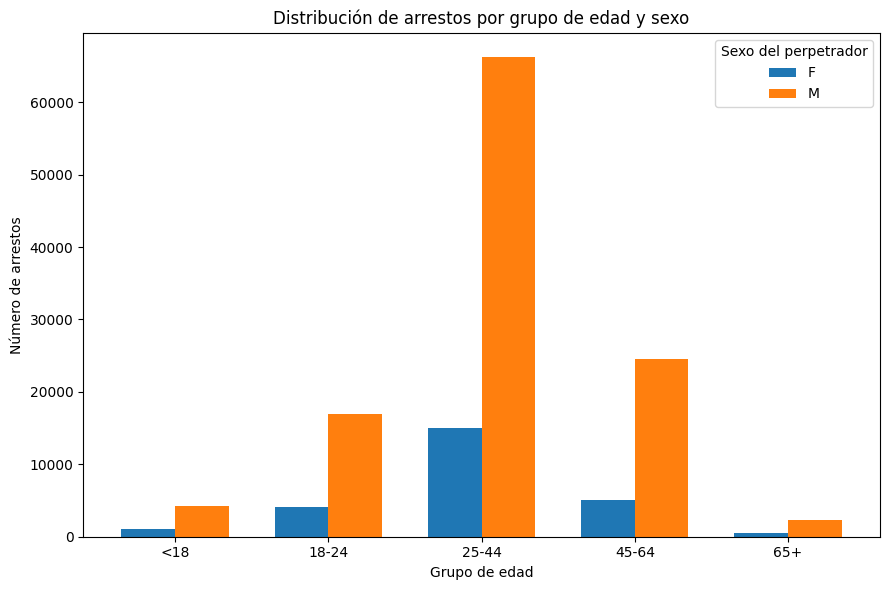

In [34]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear carpeta si no existe
os.makedirs("graficas/arrestos", exist_ok=True)

# Seleccionar columnas necesarias
df_arrestos_pd = df_arrestos.select("AGE_GROUP", "PERP_SEX").toPandas()

# Agrupar y reestructurar
conteo = df_arrestos_pd.value_counts().reset_index(name="count")
conteo = conteo.pivot(index="AGE_GROUP", columns="PERP_SEX", values="count").fillna(0)

# Orden lógico de grupos de edad
orden_edades = ["<18", "18-24", "25-44", "45-64", "65+"]
conteo = conteo.reindex(orden_edades)

# Crear gráfico
conteo.plot(kind="bar", figsize=(9, 6), width=0.7)
plt.title("Distribución de arrestos por grupo de edad y sexo")
plt.xlabel("Grupo de edad")
plt.ylabel("Número de arrestos")
plt.xticks(rotation=0)
plt.legend(title="Sexo del perpetrador")
plt.tight_layout()

# Guardar imagen
plt.savefig("graficas/arrestos/arrestos_edad_sexo.png")

# Mostrar en notebook
plt.show()


#### Gráfico 2: Top 15 delitos más frecuentes en arrestos

Se representa el número de arrestos asociados a los quince tipos de delitos más comunes. Las categorías con mayor frecuencia incluyen asalto en tercer grado, hurto menor y delitos relacionados con drogas. La visualización permite identificar los delitos que más contribuyen al volumen total de arrestos.



/tmp/ipykernel_3293716/2633831907.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_delitos, x="count", y="OFNS_DESC", palette="viridis")


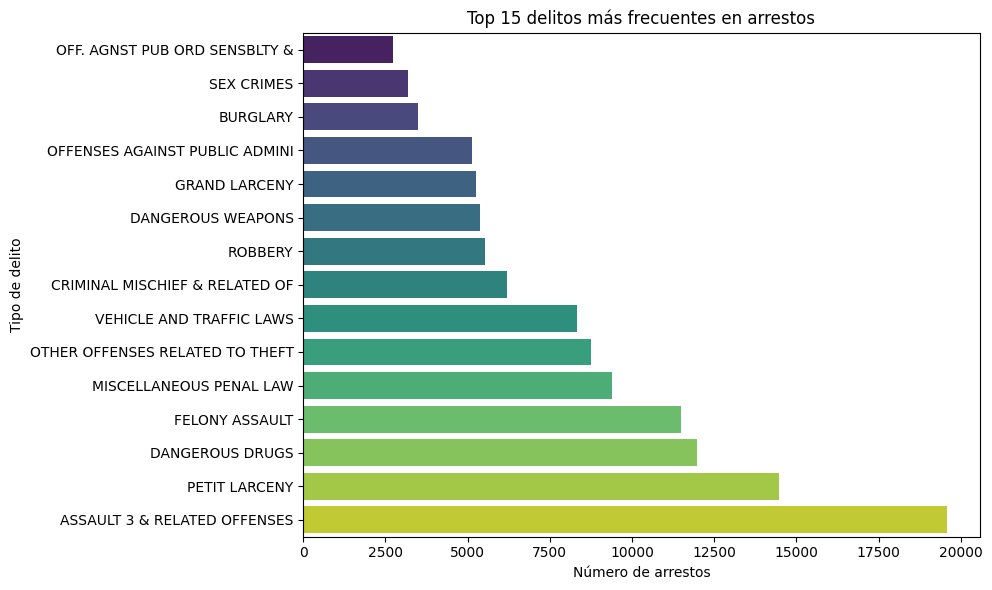

In [35]:
# Crear carpeta si no existe
os.makedirs("graficas/arrestos", exist_ok=True)

# Selección y conteo
top_delitos = (
    df_arrestos
    .groupBy("OFNS_DESC")
    .count()
    .orderBy("count", ascending=False)
    .limit(15)
    .toPandas()
    .sort_values("count", ascending=True)  # Para que la barra más grande quede arriba
)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(data=top_delitos, x="count", y="OFNS_DESC", palette="viridis")
plt.title("Top 15 delitos más frecuentes en arrestos")
plt.xlabel("Número de arrestos")
plt.ylabel("Tipo de delito")
plt.tight_layout()

# Guardar imagen
plt.savefig("graficas/arrestos/top_delitos.png")

# Mostrar en notebook
plt.show()


#### Gráfico 3: Número de arrestos por distrito (borough)

Este gráfico compara el número total de arrestos por distrito. Brooklyn presenta la mayor cantidad, seguido por Manhattan, Bronx y Queens. Staten Island aparece con una cifra significativamente menor. Esta distribución aporta una visión territorial útil para futuros cruces con indicadores sociales o económicos.



/tmp/ipykernel_3293716/1942365537.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=boro, x="ARREST_BORO", y="count", palette="Set2")


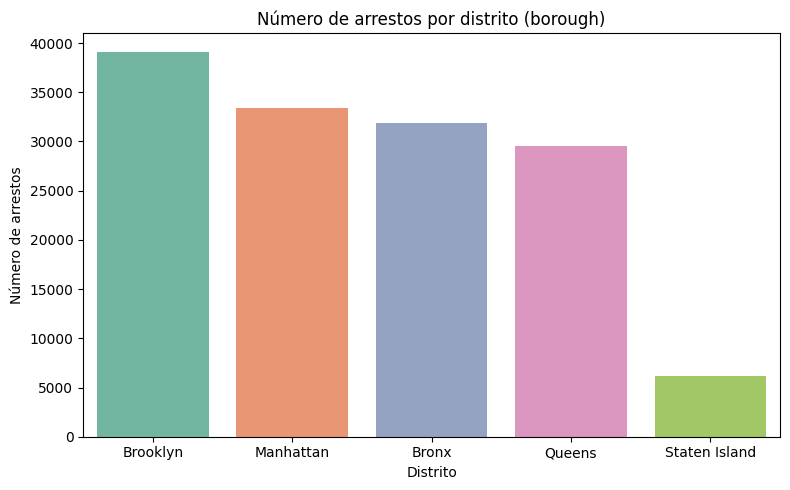

In [36]:
# Crear carpeta si no existe
os.makedirs("graficas/arrestos", exist_ok=True)

# Conteo por borough
boro = (
    df_arrestos.groupBy("ARREST_BORO").count()
    .orderBy("count", ascending=False)
    .toPandas()
)

# Mapa de códigos a nombres
mapa_boro = {"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"}
boro["ARREST_BORO"] = boro["ARREST_BORO"].map(mapa_boro)

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=boro, x="ARREST_BORO", y="count", palette="Set2")
plt.title("Número de arrestos por distrito (borough)")
plt.xlabel("Distrito")
plt.ylabel("Número de arrestos")
plt.tight_layout()

plt.savefig("graficas/arrestos/arrestos_por_borough.png")
plt.show()


#### Gráfico 4: Distribución de arrestos por raza del perpetrador

Se muestran las frecuencias de arrestos según la raza reportada de la persona arrestada. Las categorías más numerosas son Black y White Hispanic. Esta visualización permite explorar la dimensión demográfica del fenómeno y podría vincularse con estudios sobre desigualdad o discriminación.



/tmp/ipykernel_3293716/2855486770.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=raza, y="PERP_RACE", x="count", palette="Blues_d")


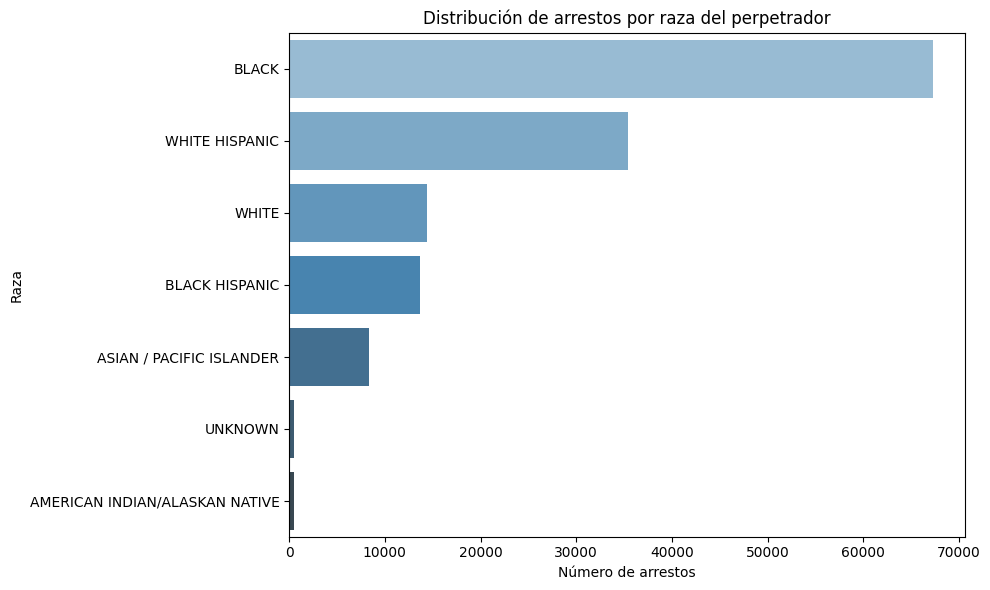

In [37]:
# Crear carpeta si no existe
os.makedirs("graficas/arrestos", exist_ok=True)

# Conteo por raza
raza = (
    df_arrestos.groupBy("PERP_RACE").count()
    .orderBy("count", ascending=False)
    .toPandas()
)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=raza, y="PERP_RACE", x="count", palette="Blues_d")
plt.title("Distribución de arrestos por raza del perpetrador")
plt.xlabel("Número de arrestos")
plt.ylabel("Raza")
plt.tight_layout()

plt.savefig("graficas/arrestos/arrestos_por_raza.png")
plt.show()


#### Gráfico 5: Distribución de arrestos por tipo legal

Se grafican las categorías legales asociadas a los arrestos: delito menor y felonía. La mayoría de los arrestos se concentra en delitos menores, lo que puede sugerir un enfoque punitivo más intenso en conductas de menor gravedad.

/tmp/ipykernel_3293716/3440462730.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=law_cat, x="LAW_CAT_CD", y="count", palette="pastel")


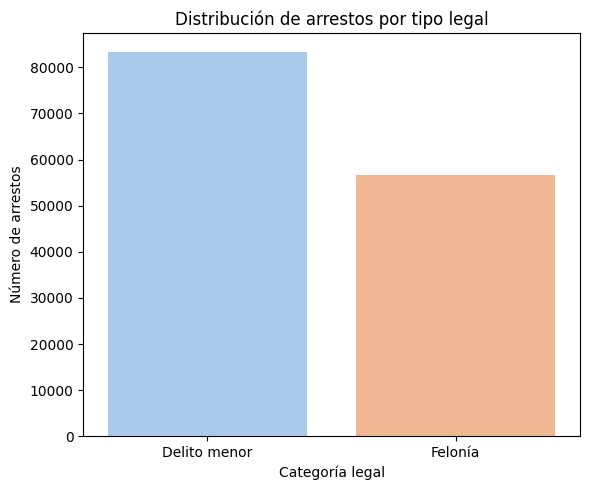

In [39]:
# Crear carpeta si no existe
os.makedirs("graficas/arrestos", exist_ok=True)

# Conteo por categoría legal
law_cat = (
    df_arrestos.groupBy("LAW_CAT_CD").count()
    .orderBy("count", ascending=False)
    .toPandas()
)

# Mapa a etiquetas más legibles
mapa_categoria = {"F": "Felonía", "M": "Delito menor", "V": "Violación"}
law_cat["LAW_CAT_CD"] = law_cat["LAW_CAT_CD"].map(mapa_categoria)

# Gráfico
plt.figure(figsize=(6, 5))
sns.barplot(data=law_cat, x="LAW_CAT_CD", y="count", palette="pastel")
plt.title("Distribución de arrestos por tipo legal")
plt.xlabel("Categoría legal")
plt.ylabel("Número de arrestos")
plt.tight_layout()

plt.savefig("graficas/arrestos/arrestos_por_tipo_legal.png")
plt.show()


### 6.2 Visualización – Motor Vehicle Collisions

A partir del conjunto de accidentes vehiculares registrados en la ciudad de Nueva York, se generaron distintas visualizaciones para explorar la frecuencia, causas y características principales de las colisiones. Estas gráficas permiten observar con mayor claridad los tipos de vehículos más involucrados, los factores que contribuyen a los choques, las zonas del vehículo afectadas y la evolución temporal de los incidentes. De esta manera, se complementa el análisis estadístico con representaciones visuales que facilitan la interpretación del comportamiento general de los datos.




#### Gráfico 1: Tipos de vehículos más involucrados

Este gráfico presenta los diez tipos de vehículos con mayor participación en accidentes. Predominan los sedanes, los station wagons o SUVs y los vehículos clasificados genéricamente como “passenger vehicle”. También se observa una cantidad considerable de registros sin información específica (NO_INFO), lo cual sugiere posibles limitaciones en la precisión del registro de datos.



/tmp/ipykernel_3293716/2401792857.py:12: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vehiculos, y="VEHICLE_TYPE", x="count", palette="Blues_d")


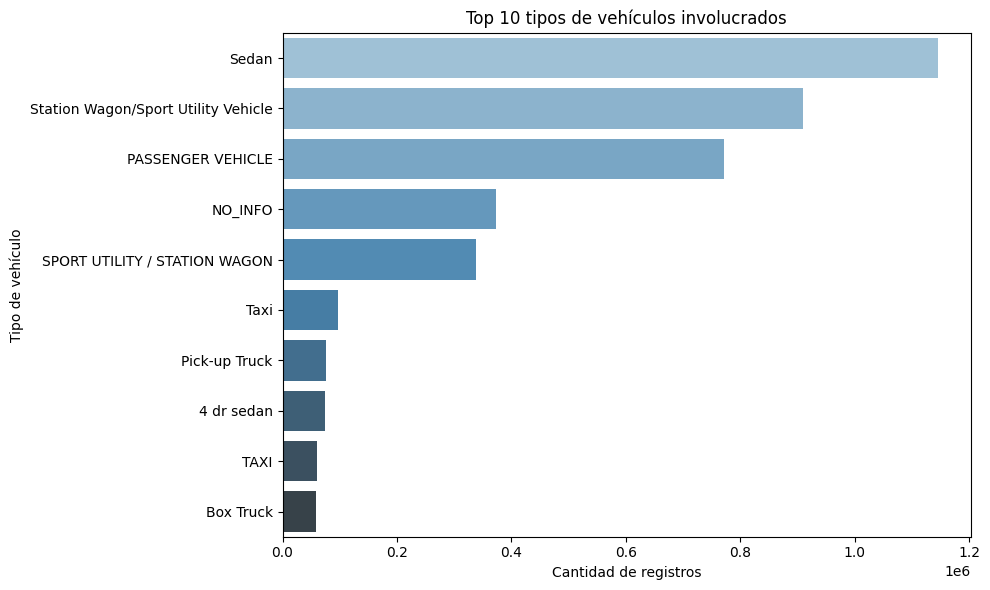

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Crear carpeta si no existe
os.makedirs("graficas/accidentes", exist_ok=True)

# Agrupar y visualizar
top_vehiculos = df_accidentes.groupBy("VEHICLE_TYPE").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_vehiculos, y="VEHICLE_TYPE", x="count", palette="Blues_d")
plt.xlabel("Cantidad de registros")
plt.ylabel("Tipo de vehículo")
plt.title("Top 10 tipos de vehículos involucrados")
plt.tight_layout()
plt.savefig("graficas/accidentes/top_tipos_vehiculos.png")
plt.show()


#### Gráfico 2: Principales factores contribuyentes

La segunda gráfica muestra las causas más frecuentes asociadas a las colisiones. Si bien la categoría NO_INFO agrupa la mayoría de los casos, entre los factores registrados destacan la distracción del conductor, no ceder el paso y conducir demasiado cerca de otro vehículo. Estos resultados reflejan que la mayoría de los incidentes están relacionados con errores humanos y comportamientos imprudentes al volante.



/tmp/ipykernel_3293716/3150916317.py:4: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_factores, y="CONTRIBUTING_FACTOR_1", x="count", palette="Oranges_r")


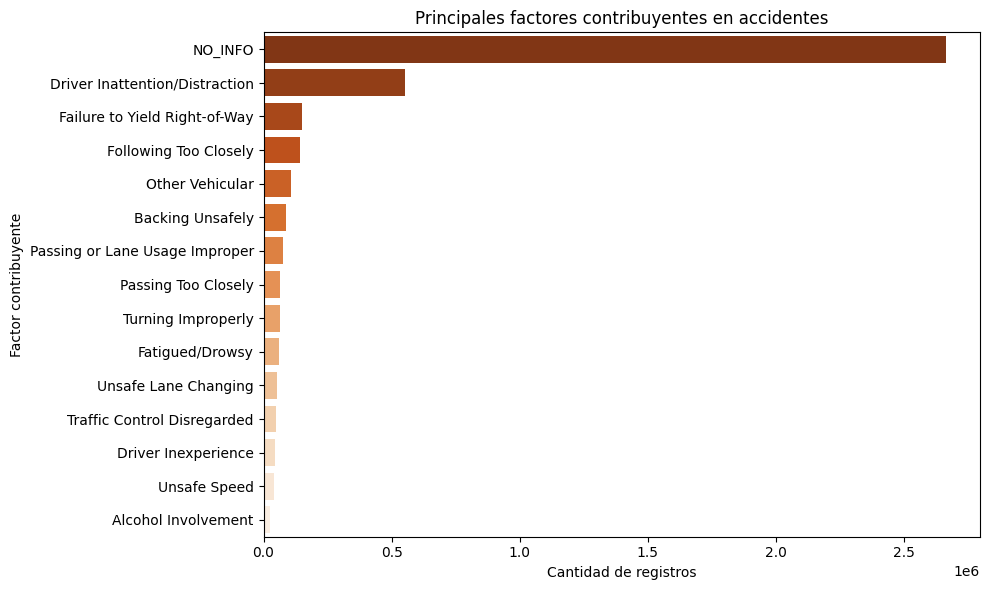

In [42]:
top_factores = df_accidentes.groupBy("CONTRIBUTING_FACTOR_1").count().orderBy("count", ascending=False).limit(15).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_factores, y="CONTRIBUTING_FACTOR_1", x="count", palette="Oranges_r")
plt.xlabel("Cantidad de registros")
plt.ylabel("Factor contribuyente")
plt.title("Principales factores contribuyentes en accidentes")
plt.tight_layout()
plt.savefig("graficas/accidentes/top_factores.png")
plt.show()


#### Gráfico 3: Puntos de impacto más comunes

En este gráfico se observan las zonas del vehículo más afectadas por los choques. Los impactos frontales son los más comunes, seguidos por golpes en las partes traseras y laterales. Este patrón sugiere que muchos de los accidentes se producen por alcances o colisiones frontales, lo que coincide con la frecuencia de causas como la distracción o la falta de distancia de seguridad.



/tmp/ipykernel_3293716/54334693.py:4: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_puntos, y="POINT_OF_IMPACT", x="count", palette="Purples_d")


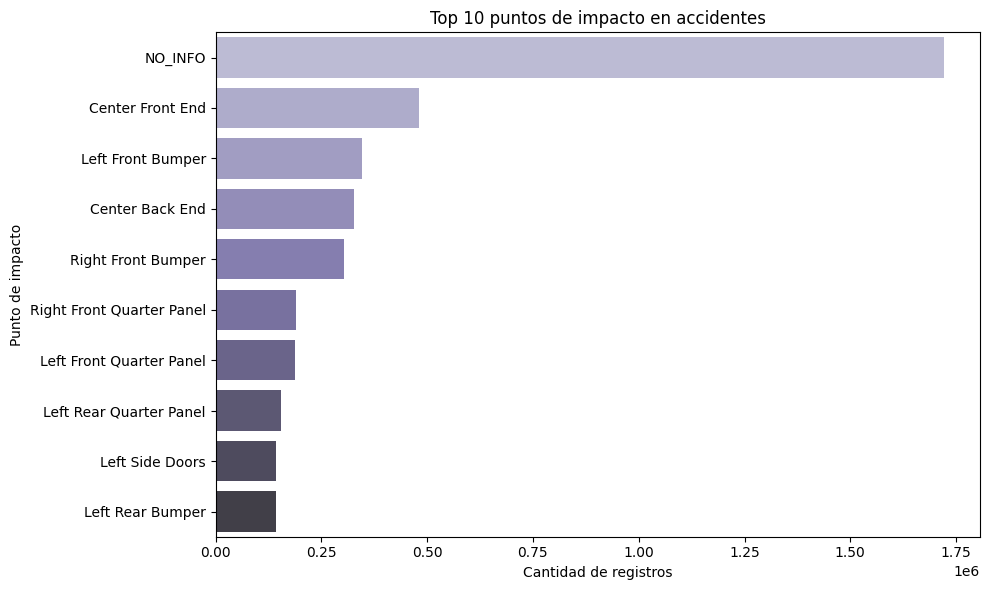

In [55]:
top_puntos = df_accidentes.groupBy("POINT_OF_IMPACT").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_puntos, y="POINT_OF_IMPACT", x="count", palette="Purples_d")
plt.xlabel("Cantidad de registros")
plt.ylabel("Punto de impacto")
plt.title("Top 10 puntos de impacto en accidentes")
plt.tight_layout()
plt.savefig("graficas/accidentes/top_impactos.png")
plt.show()


#### Gráfico 4: Condición del vehículo antes del choque

Esta visualización muestra el estado del vehículo justo antes del impacto. La mayoría de los casos corresponden a vehículos que circulaban en línea recta, seguidos por aquellos que estaban estacionados o realizando giros. Estos resultados podrían relacionarse con accidentes por descuido o por falta de atención.


/tmp/ipykernel_3293716/2625278442.py:4: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pre_crash, y="PRE_CRASH", x="count", palette="flare")


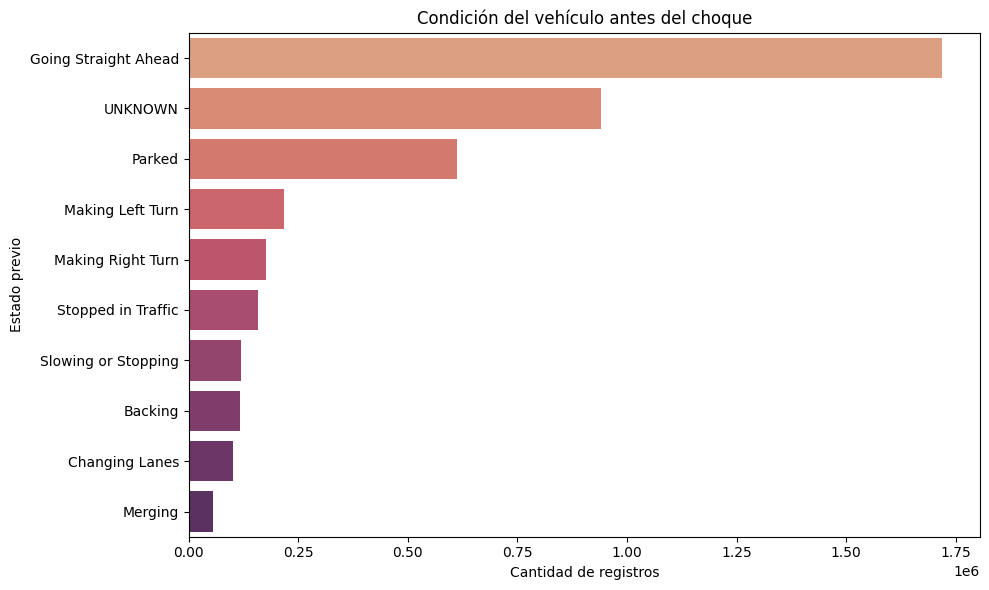

In [56]:
pre_crash = df_accidentes.groupBy("PRE_CRASH").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=pre_crash, y="PRE_CRASH", x="count", palette="flare")
plt.title("Condición del vehículo antes del choque")
plt.xlabel("Cantidad de registros")
plt.ylabel("Estado previo")
plt.tight_layout()
plt.savefig("graficas/accidentes/estado_previo_choque.png")
plt.show()



#### Gráfico 5: Evolución de colisiones por año

La última gráfica presenta la cantidad de colisiones registradas por año. Se observa un incremento sostenido entre 2013 y 2019, seguido por una disminución significativa a partir de 2020. Esta caída puede estar asociada a la pandemia y las restricciones de movilidad, aunque también podrían influir cambios en los métodos de registro o en las políticas de control vial.

/tmp/ipykernel_3293716/673748859.py:4: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=colisiones_anio, x="CRASH_YEAR", y="count", palette="crest")


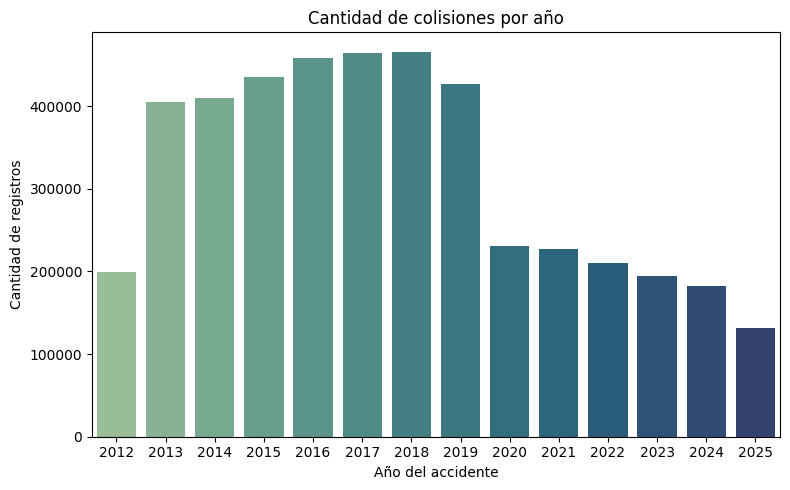

In [47]:
colisiones_anio = df_accidentes.groupBy("CRASH_YEAR").count().orderBy("CRASH_YEAR").toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=colisiones_anio, x="CRASH_YEAR", y="count", palette="crest")
plt.title("Cantidad de colisiones por año")
plt.xlabel("Año del accidente")
plt.ylabel("Cantidad de registros")
plt.tight_layout()
plt.savefig("graficas/accidentes/colisiones_por_anio.png")
plt.show()


### 6.3 Visualización – Poverty Data

A partir del conjunto de datos de pobreza en Nueva York, se construyeron visualizaciones que ayudan a ilustrar la distribución de los ingresos, la concentración de registros y las tasas de pobreza en los distintos distritos (boroughs). También se exploró la relación entre el ingreso familiar estimado y el nivel educativo alcanzado, con el fin de detectar posibles patrones estructurales asociados a la vulnerabilidad económica.

Las gráficas seleccionadas permiten complementar el análisis estadístico previo con representaciones visuales que hacen más evidente la desigualdad en la distribución del ingreso, las diferencias entre distritos y la importancia de factores como la educación.



#### Gráfico 1: Cantidad de registros por distrito

Este gráfico muestra la cantidad total de registros presentes en la base de datos para cada uno de los cinco distritos de Nueva York. Se observa que los distritos 2 y 4 concentran una mayor cantidad de datos, lo que puede estar asociado a su densidad poblacional o cobertura censal. Si bien no refleja directamente pobreza, ayuda a contextualizar la magnitud de la muestra por zona.




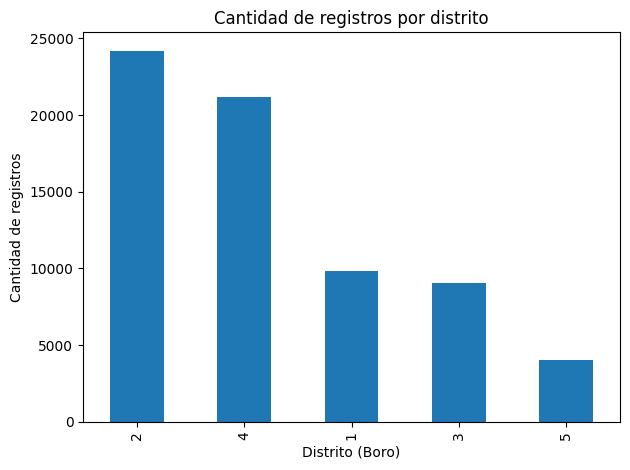

In [61]:
import os

# Crear carpeta si no existe
os.makedirs("graficas/pobreza", exist_ok=True)

# Agrupar por distrito y contar registros
df_pobreza.groupBy("Boro").count().orderBy("count", ascending=False).toPandas().plot(
    kind='bar',
    x='Boro',
    y='count',
    legend=False,
    title='Cantidad de registros por distrito'
)

plt.xlabel("Distrito (Boro)")
plt.ylabel("Cantidad de registros")
plt.tight_layout()
plt.savefig("graficas/pobreza/registros_por_boro.png")
plt.show()


#### Gráfico 2: Tasa de pobreza por distrito

A diferencia del anterior, este gráfico muestra directamente el porcentaje de personas en condición de pobreza según el distrito. Llama la atención que el distrito 1 presenta la tasa de pobreza más alta, mientras que los boroughs 3 y 5 exhiben las más bajas. Esta visualización permite contrastar la distribución espacial de la pobreza en la ciudad.





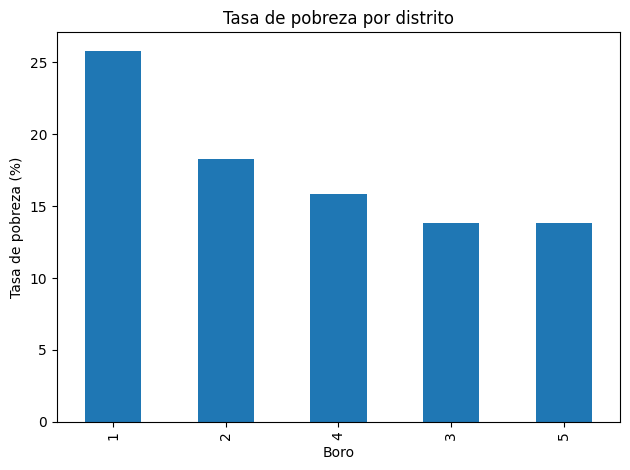

In [62]:
from pyspark.sql.functions import col

# Calcular tasa de pobreza por distrito (NYCgov_Pov_Stat == 1 indica pobreza)
df_tasa_boro = df_pobreza.groupBy("Boro").agg(
    (sum(when(col("NYCgov_Pov_Stat") == 1, 1).otherwise(0)) / count("*") * 100).alias("poverty_rate")
).orderBy("poverty_rate", ascending=False)

df_tasa_boro.toPandas().plot(
    kind='bar',
    x='Boro',
    y='poverty_rate',
    legend=False,
    title='Tasa de pobreza por distrito'
)

plt.ylabel("Tasa de pobreza (%)")
plt.tight_layout()
plt.savefig("graficas/pobreza/tasa_pobreza_boro.png")
plt.show()


#### Gráfico 3: Distribución de ingresos familiares estimados

Este histograma presenta la distribución de los ingresos familiares estimados por el gobierno de la ciudad. La forma de la curva es asimétrica, con una concentración de registros en ingresos bajos (entre 20.000 y 60.000 USD) y una larga cola hacia valores más altos. Esta visualización es útil para entender la desigualdad presente en la población.




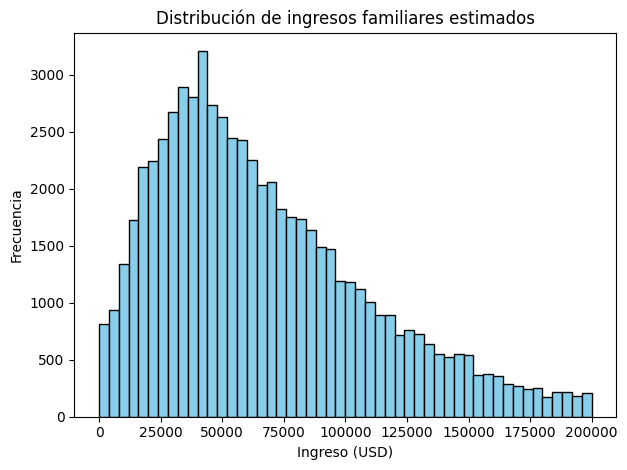

In [63]:
# Convertir a Pandas y filtrar valores extremos
df_ingresos = df_pobreza.select("NYCgov_Income").dropna().toPandas()
df_ingresos = df_ingresos[df_ingresos["NYCgov_Income"] > 0]
df_ingresos = df_ingresos[df_ingresos["NYCgov_Income"] < 200000] 

plt.hist(df_ingresos["NYCgov_Income"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribución de ingresos familiares estimados")
plt.xlabel("Ingreso (USD)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("graficas/pobreza/histograma_ingresos.png")
plt.show()



#### Gráfico 4: Boxplot del ingreso familiar

Este diagrama de caja permite observar de forma más clara la mediana, los cuartiles y los valores atípicos en la variable de ingreso familiar. Se refuerza la idea de que existen muchos hogares con ingresos bajos, pero también hay una minoría con ingresos muy altos que generan asimetría.





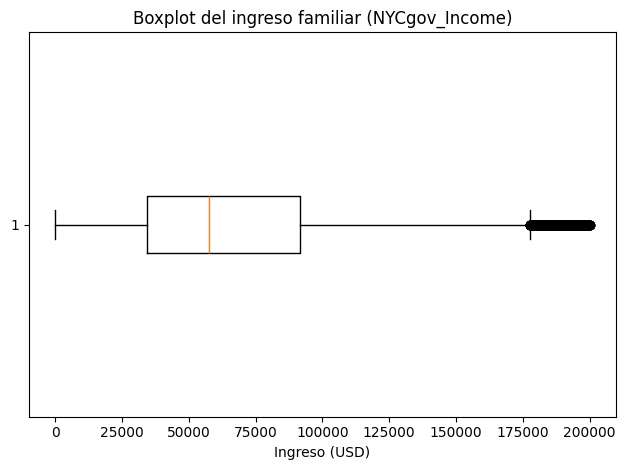

In [64]:
plt.boxplot(df_ingresos["NYCgov_Income"], vert=False)
plt.title("Boxplot del ingreso familiar (NYCgov_Income)")
plt.xlabel("Ingreso (USD)")
plt.tight_layout()
plt.savefig("graficas/pobreza/boxplot_ingresos.png")
plt.show()


#### Gráfico 5: Ingreso familiar por nivel educativo

Este gráfico muestra cómo varía el ingreso familiar según el nivel educativo alcanzado, agrupado en cuatro categorías codificadas. Aunque los niveles educativos están representados numéricamente, se puede observar una tendencia: a mayor nivel educativo, mayor ingreso promedio. Esto sugiere que la educación es un factor protector frente a la pobreza y un determinante clave en el bienestar económico de los hogares.



/tmp/ipykernel_3293716/4089959160.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_edu_ing, x="EducAttain", y="NYCgov_Income", palette="coolwarm")


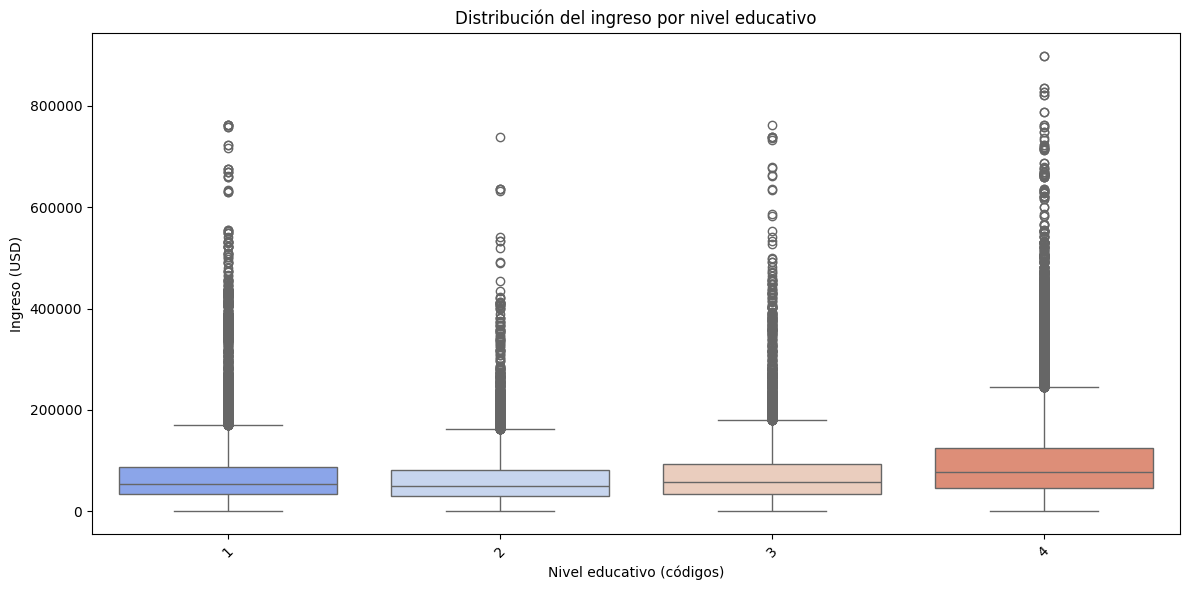

In [73]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Crear carpeta si no existe
os.makedirs("graficas/pobreza", exist_ok=True)

# Filtrar ingresos positivos y niveles educativos realistas
df_edu_ing = df_pobreza.filter(
    (col("NYCgov_Income") > 0) & 
    (col("EducAttain").isNotNull()) & 
    (col("EducAttain") <= 24)
).select("EducAttain", "NYCgov_Income").toPandas()

# Graficar boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_edu_ing, x="EducAttain", y="NYCgov_Income", palette="coolwarm")
plt.title("Distribución del ingreso por nivel educativo")
plt.xlabel("Nivel educativo (códigos)")
plt.ylabel("Ingreso (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("graficas/pobreza/ingreso_por_educacion.png")
plt.show()


### 6.4 Visualización – SAT NYC

Este conjunto de datos recoge los resultados promedio de los exámenes SAT para las escuelas públicas de la ciudad de Nueva York durante el año 2012. Las visualizaciones elaboradas permiten explorar la distribución de los puntajes en lectura crítica, matemáticas y escritura, así como las relaciones entre estas áreas. Se incluyen histogramas, boxplots y un diagrama de dispersión que complementan la visión estadística previa, facilitando la identificación de patrones generales y posibles correlaciones entre las variables.




#### Gráfico 1: Distribución de puntajes de lectura crítica

Este histograma muestra cómo se distribuyen los puntajes promedio en la sección de lectura crítica del SAT. Se observa una concentración notable de escuelas con puntajes entre 350 y 400, mientras que los valores extremos, tanto bajos como altos, son mucho menos frecuentes. La forma de la distribución sugiere una ligera asimetría hacia la derecha.



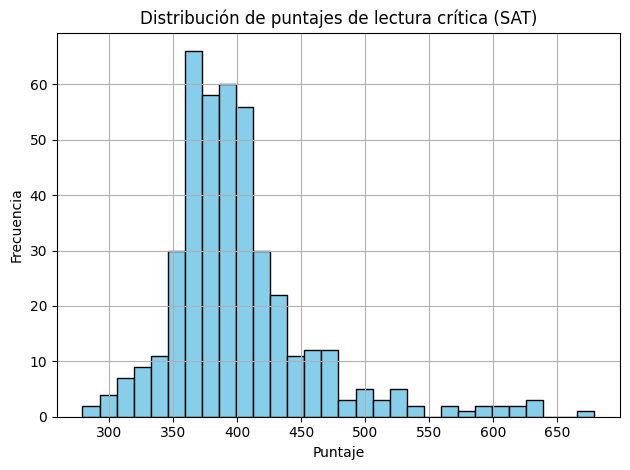

In [75]:
import os
import matplotlib.pyplot as plt

# Crear carpeta si no existe
os.makedirs("graficas/sat", exist_ok=True)

# Histograma puntajes de lectura
df_educacion.select("SAT_Critical_Reading_Avg_Score").toPandas().hist(
    column="SAT_Critical_Reading_Avg_Score",
    bins=30,
    color="skyblue",
    edgecolor="black"
)
plt.title("Distribución de puntajes de lectura crítica (SAT)")
plt.xlabel("Puntaje")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("graficas/sat/hist_lectura.png")
plt.show()


#### Gráfico 2: Distribución de puntajes de matemáticas

En este segundo histograma se representan los puntajes promedio en matemáticas. Aunque presenta una forma similar al de lectura crítica, se percibe una mayor dispersión hacia los puntajes altos, con casos que superan incluso los 700 puntos. Esto indica un mejor desempeño en esta área en comparación con las otras.


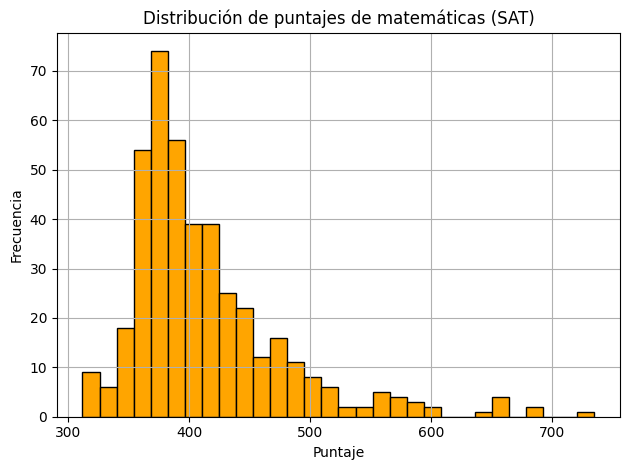

In [76]:
df_educacion.select("SAT_Math_Avg_Score").toPandas().hist(
    column="SAT_Math_Avg_Score",
    bins=30,
    color="orange",
    edgecolor="black"
)
plt.title("Distribución de puntajes de matemáticas (SAT)")
plt.xlabel("Puntaje")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("graficas/sat/hist_matematicas.png")
plt.show()



#### Gráfico 3: Distribución de puntajes de escritura

El tercer histograma se enfoca en los resultados de escritura. Al igual que en lectura, la mayoría de escuelas se agrupan entre los 350 y 400 puntos, aunque con una distribución levemente más compacta. Los valores más altos también son menos frecuentes, lo que puede reflejar mayores dificultades en esta sección.



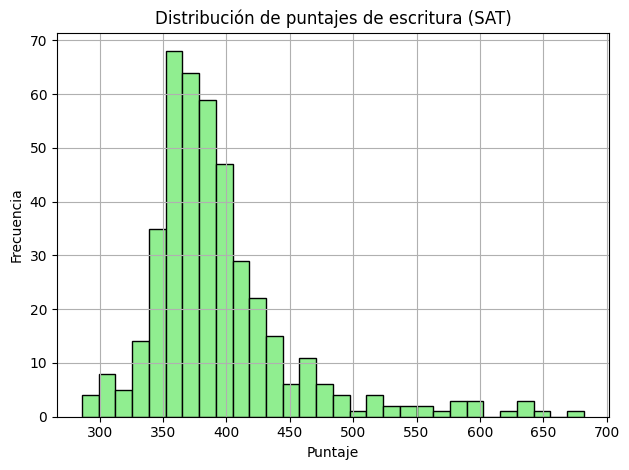

In [77]:
df_educacion.select("SAT_Writing_Avg_Score").toPandas().hist(
    column="SAT_Writing_Avg_Score",
    bins=30,
    color="lightgreen",
    edgecolor="black"
)
plt.title("Distribución de puntajes de escritura (SAT)")
plt.xlabel("Puntaje")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("graficas/sat/hist_escritura.png")
plt.show()


#### Gráfico 4: Comparación general de puntajes por componente

A través de un boxplot se comparan directamente los tres componentes del SAT. Se aprecia que las medianas de lectura y escritura son bastante similares, mientras que matemáticas tiende a presentar valores ligeramente más altos. En todas las secciones aparecen valores atípicos (outliers), lo que indica que hay algunas instituciones con rendimientos muy por encima del promedio.



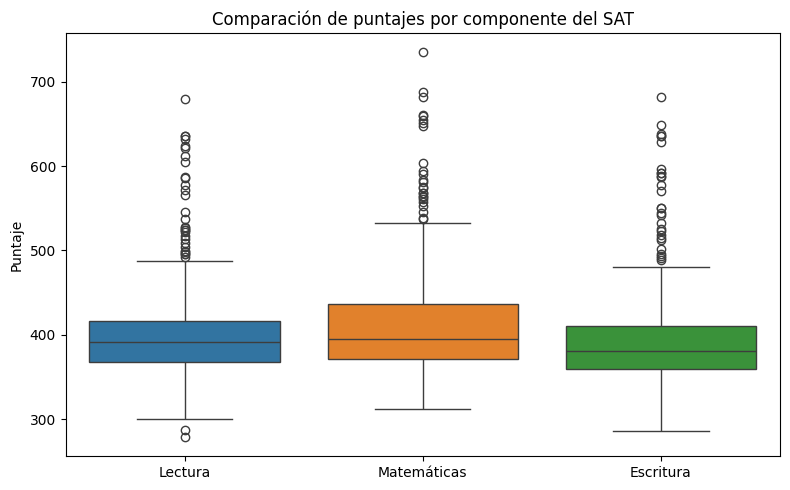

In [78]:
import seaborn as sns
import pandas as pd

# Unir columnas en un mismo DataFrame para boxplot
df_box = df_educacion.select(
    "SAT_Critical_Reading_Avg_Score",
    "SAT_Math_Avg_Score",
    "SAT_Writing_Avg_Score"
).toPandas()

df_box = df_box.rename(columns={
    "SAT_Critical_Reading_Avg_Score": "Lectura",
    "SAT_Math_Avg_Score": "Matemáticas",
    "SAT_Writing_Avg_Score": "Escritura"
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_box)
plt.title("Comparación de puntajes por componente del SAT")
plt.ylabel("Puntaje")
plt.tight_layout()
plt.savefig("graficas/sat/boxplot_puntajes.png")
plt.show()


#### Gráfico 5: Relación entre puntajes de lectura y matemáticas

Finalmente, se muestra un gráfico de dispersión que permite visualizar la relación entre los puntajes de lectura crítica y matemáticas. La tendencia ascendente es bastante evidente, lo que sugiere una correlación positiva: en general, las escuelas que obtienen buenos resultados en lectura también tienden a destacar en matemáticas.

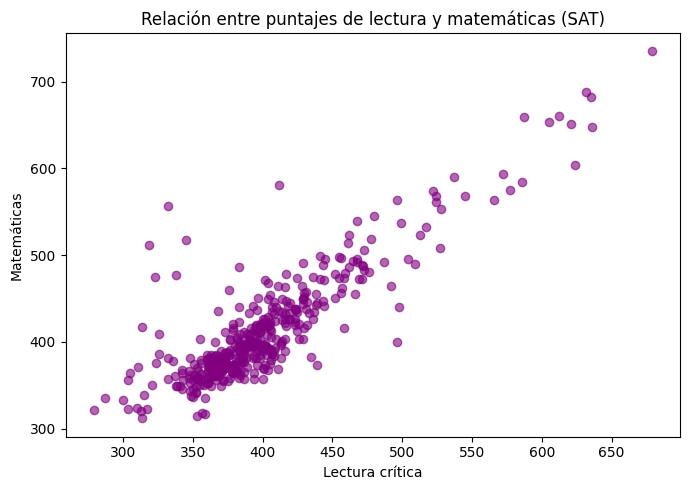

In [79]:
df_disp = df_educacion.select(
    "SAT_Critical_Reading_Avg_Score",
    "SAT_Math_Avg_Score"
).toPandas()

plt.figure(figsize=(7, 5))
plt.scatter(
    df_disp["SAT_Critical_Reading_Avg_Score"],
    df_disp["SAT_Math_Avg_Score"],
    alpha=0.6,
    color="purple"
)
plt.title("Relación entre puntajes de lectura y matemáticas (SAT)")
plt.xlabel("Lectura crítica")
plt.ylabel("Matemáticas")
plt.tight_layout()
plt.savefig("graficas/sat/dispersion_lectura_matematicas.png")
plt.show()


## WEB SCRAPPING  

Como parte del proceso de exploración externa, se realizaron consultas a diferentes APIs públicas del portal NYC Open Data usando `requests`.

Primero se probó con el dataset de resultados del SAT por escuela (`f9bf-2cp4`). Se hizo una solicitud simple limitada a 10 registros para obtener una vista preliminar del contenido. La respuesta fue exitosa (status 200) y mostró campos como `school_name`, `num_of_sat_test_takers` y los puntajes promedios en lectura, matemáticas y escritura. 

Luego se consultó el dataset de arrestos (`uip8-fykc`), también con un límite de 10 filas. Este dataset contiene una gran cantidad de columnas, incluyendo la fecha del arresto, tipo de delito, código legal, barrio (`arrest_boro`), grupo de edad, sexo, raza y coordenadas geográficas. La respuesta también fue exitosa.

Después se revisó el dataset de pobreza (`cts7-vksw`), que contiene datos simulados de hogares en NYC, incluyendo ingresos estimados, gastos, tipo de hogar, nivel educativo, estatus migratorio, entre muchos otros campos.

Finalmente, se accedió al dataset de vehículos involucrados en accidentes (`bm4k-52h4`), limitado también a 10 filas. Se validó que contiene campos como `crash_date`, `vehicle_type`, `contributing_factor_1` y `vehicle_damage`, que son útiles para caracterizar los incidentes.


In [33]:
import requests, json

BASE = "https://data.cityofnewyork.us/resource/f9bf-2cp4.json"

params = {
    "$limit": 10  
}

r = requests.get(BASE, params=params, timeout=30)
print("Status:", r.status_code)
print(r.text[:300])  
r.raise_for_status()

rows = r.json()
print("Filas:", len(rows))
print(json.dumps(rows, indent=2)[:2000])

if rows:
    print("\nColumnas disponibles:", list(rows[0].keys()))


Status: 200
[{"dbn":"01M292","school_name":"HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES","num_of_sat_test_takers":"29","sat_critical_reading_avg_score":"355","sat_math_avg_score":"404","sat_writing_avg_score":"363"}
,{"dbn":"01M448","school_name":"UNIVERSITY NEIGHBORHOOD HIGH SCHOOL","num_of_sat_test_takers":
Filas: 10
[
  {
    "dbn": "01M292",
    "school_name": "HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES",
    "num_of_sat_test_takers": "29",
    "sat_critical_reading_avg_score": "355",
    "sat_math_avg_score": "404",
    "sat_writing_avg_score": "363"
  },
  {
    "dbn": "01M448",
    "school_name": "UNIVERSITY NEIGHBORHOOD HIGH SCHOOL",
    "num_of_sat_test_takers": "91",
    "sat_critical_reading_avg_score": "383",
    "sat_math_avg_score": "423",
    "sat_writing_avg_score": "366"
  },
  {
    "dbn": "01M450",
    "school_name": "EAST SIDE COMMUNITY SCHOOL",
    "num_of_sat_test_takers": "70",
    "sat_critical_reading_avg_score": "377",
    "sat_math_avg_score": "402",
   

In [34]:
import requests, json

BASE = "https://data.cityofnewyork.us/resource/uip8-fykc.json"

params = {
    "$limit": 10  
}

r = requests.get(BASE, params=params, timeout=30)
print("Status:", r.status_code)
print(r.text[:300])  
r.raise_for_status()

rows = r.json()
print("Filas:", len(rows))
print(json.dumps(rows, indent=2)[:2000])

if rows:
    print("\nColumnas disponibles:", list(rows[0].keys()))


Status: 200
[{"arrest_key":"298748497","arrest_date":"2025-01-01T00:00:00.000","pd_cd":"153","pd_desc":"RAPE 3","ky_cd":"104","ofns_desc":"RAPE","law_code":"PL 1302501","law_cat_cd":"F","arrest_boro":"M","arrest_precinct":"28","jurisdiction_code":"0","age_group":"65+","perp_sex":"M","perp_race":"WHITE","x_coord
Filas: 10
[
  {
    "arrest_key": "298748497",
    "arrest_date": "2025-01-01T00:00:00.000",
    "pd_cd": "153",
    "pd_desc": "RAPE 3",
    "ky_cd": "104",
    "ofns_desc": "RAPE",
    "law_code": "PL 1302501",
    "law_cat_cd": "F",
    "arrest_boro": "M",
    "arrest_precinct": "28",
    "jurisdiction_code": "0",
    "age_group": "65+",
    "perp_sex": "M",
    "perp_race": "WHITE",
    "x_coord_cd": "997407",
    "y_coord_cd": "233806",
    "latitude": "40.8084177460021",
    "longitude": "-73.9524740603515",
    "geocoded_column": {
      "type": "Point",
      "coordinates": [
        -73.9524740603515,
        40.8084177460021
      ]
    },
    ":@computed_region_f5dn_y

In [35]:
import requests, json

BASE = "https://data.cityofnewyork.us/resource/cts7-vksw.json"

params = {
    "$limit": 10  
}

r = requests.get(BASE, params=params, timeout=30)
print("Status:", r.status_code)
print(r.text[:300])  
r.raise_for_status()

rows = r.json()
print("Filas:", len(rows))
print(json.dumps(rows, indent=2)[:2000])

if rows:
    print("\nColumnas disponibles:", list(rows[0].keys()))


Status: 200
[{"serialno":"1","sporder":"1","pwgtp":"95","wgtp":"95","agep":"31","cit":"1","rel":"0","sch":"1","schg":"0","schl":"22","sex":"2","esr":"1","lanx":"2","msp":"6","mar":"5","wkw":"1","wkhp":"60","dis":"2","jwtr":"12","np":"1","ten":"2","hht":"6","agecateg":"2","boro":"2","citizenstatus":"1","educatta
Filas: 10
[
  {
    "serialno": "1",
    "sporder": "1",
    "pwgtp": "95",
    "wgtp": "95",
    "agep": "31",
    "cit": "1",
    "rel": "0",
    "sch": "1",
    "schg": "0",
    "schl": "22",
    "sex": "2",
    "esr": "1",
    "lanx": "2",
    "msp": "6",
    "mar": "5",
    "wkw": "1",
    "wkhp": "60",
    "dis": "2",
    "jwtr": "12",
    "np": "1",
    "ten": "2",
    "hht": "6",
    "agecateg": "2",
    "boro": "2",
    "citizenstatus": "1",
    "educattain": "4",
    "est_childcare": "0",
    "est_commuting": "1722",
    "est_eitc": "0",
    "est_ficatax": "9765.2422",
    "est_heap": "0",
    "est_housing": "1478.3278",
    "est_incometax": "33580.543",
    "est_moop"

In [36]:
import requests, json

BASE = "https://data.cityofnewyork.us/resource/bm4k-52h4.json"

params = {
    "$limit": 10  
}

r = requests.get(BASE, params=params, timeout=30)
print("Status:", r.status_code)
print(r.text[:300])  
r.raise_for_status()

rows = r.json()
print("Filas:", len(rows))
print(json.dumps(rows, indent=2)[:2000])

if rows:
    print("\nColumnas disponibles:", list(rows[0].keys()))


Status: 200
[{"unique_id":"10385780","collision_id":"100201","crash_date":"2012-09-07T00:00:00.000","crash_time":"9:03","vehicle_id":"1","state_registration":"NY","vehicle_type":"PASSENGER VEHICLE","contributing_factor_1":"Unspecified"}
,{"unique_id":"19140702","collision_id":"4213082","crash_date":"2019-09-23T
Filas: 10
[
  {
    "unique_id": "10385780",
    "collision_id": "100201",
    "crash_date": "2012-09-07T00:00:00.000",
    "crash_time": "9:03",
    "vehicle_id": "1",
    "state_registration": "NY",
    "vehicle_type": "PASSENGER VEHICLE",
    "contributing_factor_1": "Unspecified"
  },
  {
    "unique_id": "19140702",
    "collision_id": "4213082",
    "crash_date": "2019-09-23T00:00:00.000",
    "crash_time": "8:15",
    "vehicle_id": "0553ab4d-9500-4cba-8d98-f4d7f89d5856",
    "state_registration": "NY",
    "vehicle_type": "Station Wagon/Sport Utility Vehicle",
    "vehicle_make": "TOYT -CAR/SUV",
    "vehicle_year": "2002",
    "travel_direction": "North",
    "vehicle_oc

In [67]:
!pip install beautifulsoup4 html5lib pandas matplotlib openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 250 kB 8.8 MB/s            


## Proceso de web scrapping
Dado que el enlace original para hacer scraping de la población por vecindario en Nueva York ya no está disponible (`https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm`), se usó como alternativa la API del U.S. Census Bureau. Esta API permite acceder a los datos oficiales de población por condado, lo cual en Nueva York corresponde a los cinco estados principales: Bronx, Brooklyn (Kings), Manhattan (New York), Queens y Staten Island (Richmond).

Se usaron los códigos FIPS de cada uno y se consultó la variable `B01003_001E`, que representa la población total según el American Community Survey (ACS) 5-year 2020. Los datos se organizaron en un DataFrame y se procesaron para dejar solo los nombres de los boroughs y sus respectivas poblaciones. El resultado muestra a Brooklyn como el más poblado (2.57 millones), seguido por Queens (2.27 millones), Manhattan (1.63 millones), el Bronx (1.42 millones) y Staten Island (475 mil).

Con esta información se generó un gráfico de barras horizontales que resume visualmente cómo se distribuye la población en la ciudad. Esta distribución servirá como base para normalizar otras métricas más adelante, como por ejemplo la cantidad de arrestos o accidentes por cada 100 mil habitantes.


                    borough  population
0          Brooklyn (Kings)     2576771
1                    Queens     2270976
2      Manhattan (New York)     1629153
3                     Bronx     1427056
4  Staten Island (Richmond)      475596


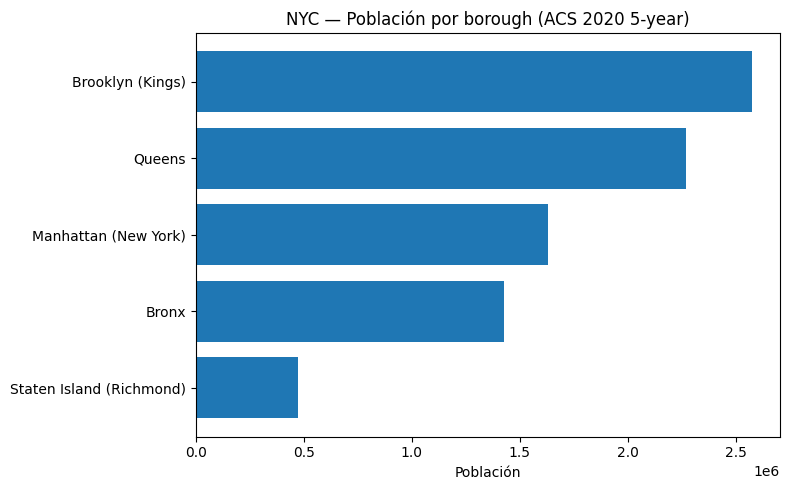

In [72]:
#LA URL: https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.html NO ESTA DISPONIBLE

import requests, pandas as pd, matplotlib.pyplot as plt

# ACS 5-year 2020: variable total población
VAR = "B01003_001E"
URL = "https://api.census.gov/data/2020/acs/acs5"

# Códigos FIPS de los 5 boroughs (condados) de NYC
BOROUGHS = {
    "005": "Bronx",
    "047": "Brooklyn (Kings)",
    "061": "Manhattan (New York)",
    "081": "Queens",
    "085": "Staten Island (Richmond)"
}

params = {
    "get": f"NAME,{VAR}",
    "for": "county:" + ",".join(BOROUGHS.keys()),
    "in": "state:36"  # New York
}
r = requests.get(URL, params=params, timeout=30)
r.raise_for_status()
data = r.json()

# A DataFrame
cols = data[0]
rows = data[1:]
df = pd.DataFrame(rows, columns=cols)

# Limpieza
df["county"] = df["county"].astype(str)
df["borough"] = df["county"].map(BOROUGHS)
df["population"] = pd.to_numeric(df[VAR], errors="coerce")
df = df[["borough", "population"]].sort_values("population", ascending=False).reset_index(drop=True)

print(df)

# Gráfico
plt.figure(figsize=(8,5))
plt.barh(df["borough"].iloc[::-1], df["population"].iloc[::-1])
plt.title("NYC — Población por borough (ACS 2020 5-year)")
plt.xlabel("Población")
plt.tight_layout()
plt.show()


### Extracción de datos climáticos (Bono OpenWeatherMap)

En esta sección se realizó una consulta a la API de OpenWeatherMap utilizando el endpoint de pronóstico a 5 días con cortes cada 3 horas. La ciudad consultada fue New York (US) y se obtuvieron variables como temperatura, humedad, precipitación (lluvia y nieve), velocidad del viento y el estado general del clima.

La respuesta fue satisfactoria (status 200), y se construyó un DataFrame ordenado cronológicamente con los datos. Como parte del análisis inicial, se imprimieron las primeras 12 observaciones, donde se evidenciaban patrones como cielos despejados en las primeras horas, seguidos por episodios de lluvia ligera durante la madrugada del 22 de octubre. También se observaron temperaturas que oscilaban entre los 19°C y los 11°C en esas primeras entradas.

Se generaron dos visualizaciones a partir de estos datos. La primera muestra la evolución de la temperatura a lo largo de los días junto con la cantidad de precipitación registrada en cada intervalo de 3 horas. Este gráfico permite identificar los ciclos térmicos diarios, así como los momentos puntuales en los que se esperan lluvias. Por ejemplo, el día 22 se concentra la mayor cantidad de precipitación, con una combinación de caídas moderadas y ligeras.

La segunda visualización resume las temperaturas máximas y mínimas por día, junto con la lluvia total diaria acumulada. El análisis diario muestra un descenso progresivo de la temperatura a lo largo de los cinco días, con un pico inicial cercano a los 20°C el 21 de octubre, bajando hasta un promedio de 14°C al final del periodo. La única jornada con lluvia significativa fue el 22 de octubre, acumulando más de 4.5 mm, mientras que el resto de días permanecen secos según el pronóstico.


Status: 200
Ubicación: New York, US


,dt_local,temp,humidity,rain_3h,weather
0,2025-10-21 17:00:00+00:00,19.68,49,0.00,clear sky
1,2025-10-21 20:00:00+00:00,18.99,52,0.00,clear sky
2,2025-10-21 23:00:00+00:00,17.58,58,0.00,broken clouds
3,2025-10-22 02:00:00+00:00,15.51,76,0.86,light rain
4,2025-10-22 05:00:00+00:00,14.45,83,2.34,light rain
5,2025-10-22 08:00:00+00:00,14.13,84,1.39,light rain
6,2025-10-22 11:00:00+00:00,15.16,52,0.00,clear sky
7,2025-10-22 14:00:00+00:00,17.16,38,0.00,clear sky
8,2025-10-22 17:00:00+00:00,16.24,40,0.00,scattered clouds
9,2025-10-22 20:00:00+00:00,14.00,43,0.00,few clouds


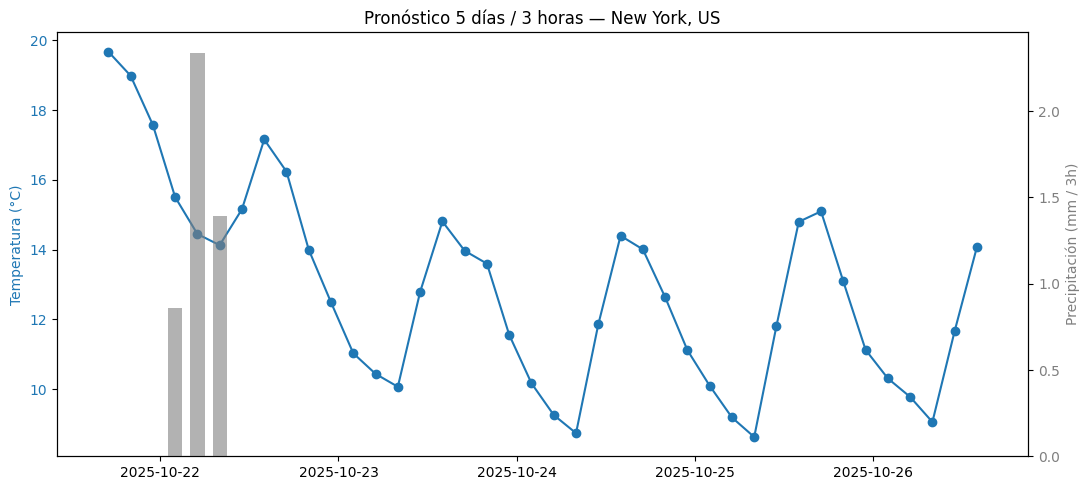

,date,temp_min,temp_max,lluvia_mm
0,2025-10-21,16.53,19.98,0.00
1,2025-10-22,12.49,17.16,4.59
2,2025-10-23,10.07,14.81,0.00
3,2025-10-24,8.74,14.40,0.00
4,2025-10-25,8.63,15.10,0.00
5,2025-10-26,9.06,14.08,0.00


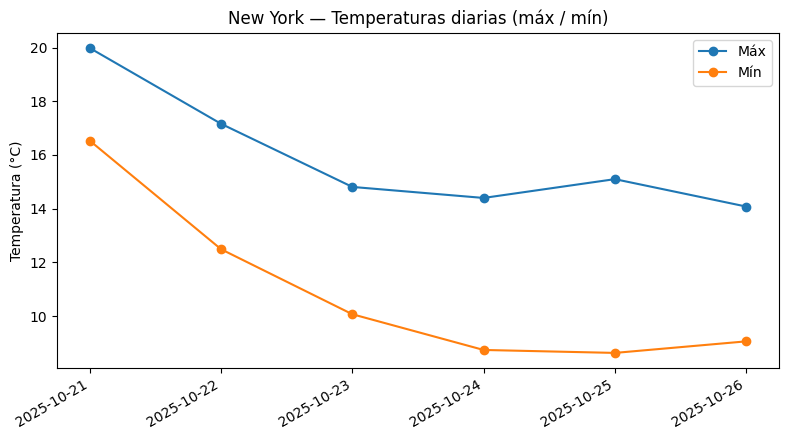

In [6]:

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Configuración de la API 
API_KEY = "e7a0fa7a390f7386e06999c9c0c0012a" 
CITY = "New York,US"
UNITS = "metric"  

# Llamado a la API de OpenWeatherMap 
params = {
    "q": CITY,
    "appid": API_KEY,
    "units": UNITS
}

response = requests.get("https://api.openweathermap.org/data/2.5/forecast", params=params, timeout=30)
print("Status:", response.status_code)
response.raise_for_status()
data = response.json()

# Parseo y construcción del DataFrame 
rows = []
for entry in data["list"]:
    main = entry.get("main", {})
    wind = entry.get("wind", {})
    rain = entry.get("rain", {})
    snow = entry.get("snow", {})
    rows.append({
        "dt_utc": pd.to_datetime(entry["dt"], unit="s", utc=True),
        "temp": main.get("temp"),
        "temp_min": main.get("temp_min"),
        "temp_max": main.get("temp_max"),
        "humidity": main.get("humidity"),
        "wind_speed": wind.get("speed"),
        "rain_3h": rain.get("3h", 0.0),
        "snow_3h": snow.get("3h", 0.0),
        "weather": entry.get("weather", [{}])[0].get("description")
    })

df = pd.DataFrame(rows).sort_values("dt_utc").reset_index(drop=True)

# Ajuste a hora local según el timezone del lugar
tz_shift_s = data.get("city", {}).get("timezone", 0)
df["dt_local"] = df["dt_utc"] + pd.to_timedelta(tz_shift_s, unit="s")

# Mostrar tabla resumen de las próximas horas
cols = ["dt_local", "temp", "humidity", "rain_3h", "weather"]
print("Ubicación:", f'{data["city"]["name"]}, {data["city"]["country"]}')
display(df[cols].head(12))

# Gráfico 1: Pronóstico 5 días (temperatura y precipitación)

# Crear carpeta si no existe
os.makedirs("graficas/clima", exist_ok=True)

fig, ax1 = plt.subplots(figsize=(11,5))
ax1.plot(df["dt_local"], df["temp"], marker="o", color="tab:blue", label="Temperatura")
ax1.set_title(f"Pronóstico 5 días / 3 horas — {data['city']['name']}, {data['city']['country']}")
ax1.set_ylabel(f"Temperatura ({'°C' if UNITS=='metric' else '°F'})", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Precipitación en eje secundario
ax2 = ax1.twinx()
ax2.bar(df["dt_local"], df["rain_3h"] + df["snow_3h"], width=0.08, color="tab:gray", alpha=0.6, label="Precipitación")
ax2.set_ylabel("Precipitación (mm / 3h)", color="tab:gray")
ax2.tick_params(axis='y', labelcolor="tab:gray")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("graficas/clima/clima_nyc_forecast.png")
plt.show()

# Gráfico 2: temperatura máx/mín y lluvia total
daily = (
    df.assign(date=df["dt_local"].dt.date)
    .groupby("date")
    .agg(temp_min=("temp_min", "min"),
         temp_max=("temp_max", "max"),
         lluvia_mm=("rain_3h", "sum"))
    .reset_index()
)

display(daily)

plt.figure(figsize=(8, 4.5))
plt.plot(daily["date"], daily["temp_max"], marker="o", label="Máx")
plt.plot(daily["date"], daily["temp_min"], marker="o", label="Mín")
plt.title(f"{data['city']['name']} — Temperaturas diarias (máx / mín)")
plt.ylabel(f"Temperatura ({'°C' if UNITS=='metric' else '°F'})")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig("graficas/clima/clima_nyc_diario.png")
plt.show()
